# Automation Risk and Voting Outcomes in recent US Presidential Elections

### SUMMARY OF SCRIPT:

This script imports, visualises, and analyses data describing voting outcomes at the county level for recent Presidental Elections and Primaries in the United States and a variety of demographic data for those counties, most importantly the composition of their labour markets. 

The data is first read in and then visualed so as to understand its structure and check for correlations.

After this the hypothesis that working in a job that is susceptable to be automated is a major causal factor in support for radical political candidates is investigated using multivariate regressions of the cross-sectional data. 

Expanding on Frey et al's (2018) findings that the percentage of a US county's workforce in easily automatable work served as a strong predictor for the county's likelihood to vote Republican, this analysis find that the effect does not recurr in the 2020 Presidential Election. 

The script also investigates whether the candidacy of Bernie Sanders benefited from this effect with inconclusive results.

## SET UP

In [2]:
#Import relevant dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

### DESCRIPTION OF THE DATA:

The analysis of all votes was performed at the county level. To identify the labour market and
demographic composition of each county, I rely on data from the 2015 and 2019 American 
Community Surveys (ASC), which proves a one percent sample of each county’ population which can 
be matched to electoral results (Ruggles et al, 2017). The approach details the voting outcomes for 
some 3,107 counties across the continental United States. The ACS division the labour market into 
five broad classes of occupations: 

 - (1) Management, Business, Science, and Arts occupations
 - (2) Service occupations
 - (3) Sales and Office occupations
 - (4) Natural Resources, Construction, and Maintenance occupations 
 - (5) Production, Transportation, and Material moving occupations 

In line with the definitions provided in Jaimovich and Siu (2012) and Autor and Dorn (2013) I 
classify the latter three occupational categories as consisting of “routine jobs”, and therefore being 
susceptible to automation. 

The sum of the percentages of the labour market, comprised of Sales and 
Office occupations, Natural Resources, Construction, and Maintenance occupations, and Production, 
Transportation, and Material moving occupations, is included as a column measuring 
the percentage of the labour market at risk of automation in a given election year. 

To investigate the link between voters’ differing levels of exposure to automation and their propensity
to vote for an anti-status quo candidate, county level voting results outcomes, sourced from David
Leip’s Atlas of US Elections (Leip, 2021), was used to construct variables measuring the difference in 
Republican vote-share between the 2020 and 2016 elections and the 2016 and 2012 elections as well 
as the difference in vote-share received by Sanders in the 2020 and 2016 primaries.

It should be noted that the analysis of the Presidential Elections excludes the states of Hawaii and Alaska due to geographic discontinuity in line with previous analysis of these phenomena (Frey et al, 2018). Analysis of the Democratic Primaries additionally excludes the District of Columbia and Puerto Rico for coherence with the results of the General Election, as well as the states of Kansas, Maine, Minnesota, and North Dakota due to data limitations. This is assumed not to bias the overall analysis.

### Import the data

In [3]:
#Voting and demographic data for the Presidential Elections 
PresData = pd.read_csv ("C:\\Users\\user\\Documents\\Python_Projects\\political_machines\\Automation_Project_Presidential_Data.csv")

#Voting and demographic data for the Democratic Primaries  
PrimData = pd.read_csv ("C:\\Users\\user\\Documents\\Python_Projects\\political_machines\\Automation_Project_Primary_Data.csv")

### Data Cleaning & Exploration

In [4]:
type(PresData)

pandas.core.frame.DataFrame

In [5]:
#CHECK THAT THIS CAN BE DONE IN 1 CELL
type(PrimData)

pandas.core.frame.DataFrame

In [6]:
PresData

,GEO_ID,State_&_Country,County_Number,State,County,State_Code,State_Number,Total_Vote_2020,Margin_2020,Trump_2020,...,Unnamed: 50,Biden,Clinton,Obama,Biden_2020,Clinton_2016,Gen_Vote_2020,Vote_Weight_2020,Gen_Vote_2016,Vote_Weight_2016
0,0500000US01001,"Autauga County, Alabama",1,Alabama,Autauga,AL,1,27770,12335,0.714368,...,NaN,0.2702,0.2377,0.2654,0.0325,-0.0277,27770,0.548498,"24,973",0.583273
1,0500000US01003,"Baldwin County, Alabama",2,Alabama,Baldwin,AL,1,109679,58966,0.761714,...,NaN,0.2241,0.1939,0.2155,0.0302,-0.0217,109679,2.166322,"95,215",2.223855
2,0500000US01005,"Barbour County, Alabama",3,Alabama,Barbour,AL,1,10518,806,0.534512,...,NaN,0.4579,0.4653,0.5133,-0.0074,-0.0480,10518,0.207746,"10,469",0.244515
3,0500000US01007,"Bibb County, Alabama",4,Alabama,Bibb,AL,1,9595,5539,0.784263,...,NaN,0.2070,0.2125,0.2615,-0.0055,-0.0490,9595,0.189515,"8,819",0.205978
4,0500000US01009,"Blount County, Alabama",5,Alabama,Blount,AL,1,27588,22071,0.895716,...,NaN,0.0957,0.0843,0.1234,0.0114,-0.0392,27588,0.544904,"25,588",0.597637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0500000US56037,"Sweetwater County, Wyoming",3138,Wyoming,Sweetwater,WY,49,16603,8406,0.736554,...,NaN,0.2303,0.1886,0.2826,0.0416,-0.0940,16603,0.327934,"17,130",0.400091
3103,0500000US56039,"Teton County, Wyoming",3139,Wyoming,Teton,WY,49,14677,5507,0.295769,...,NaN,0.6710,0.5792,0.5420,0.0917,0.0373,14677,0.289892,"12,627",0.294918
3104,0500000US56041,"Uinta County, Wyoming",3140,Wyoming,Uinta,WY,49,9402,5905,0.797277,...,NaN,0.1692,0.1419,0.1907,0.0273,-0.0487,9402,0.185703,"8,470",0.197826
3105,0500000US56043,"Washakie County, Wyoming",3141,Wyoming,Washakie,WY,49,4012,2594,0.808824,...,NaN,0.1623,0.1395,0.2013,0.0228,-0.0618,4012,0.079243,"3,814",0.089080


In [7]:
#Check data types in PresData
PresData.dtypes

GEO_ID                                                                                                                                object
State_&_Country                                                                                                                       object
County_Number                                                                                                                          int64
State                                                                                                                                 object
County                                                                                                                                object
State_Code                                                                                                                            object
State_Number                                                                                                                           int64
Total_Vote_20

In [8]:
for col_name in PresData:
    print(col_name)

GEO_ID
State_&_Country
County_Number
State
County
State_Code
State_Number
Total_Vote_2020
Margin_2020
Trump_2020
Total_Vote_2016
Trump_2016
Trump_Difference_2020
Percent_Workforce_Automation_Risk_2019
Estimate!!SEX AND AGE!!Total population_2019
Estimate!!SEX AND AGE!!Total population_2016
Population_Difference_2019
Percentage_Population_Difference_2019
Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force_2019
Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force_2016
Percentage_Change_Employment_2019
Percentage_Asian_2019
Percentage_Black_2019
Percentage_Female_2019
Percentage_Hispanic_2019
Percentage_Foreign_born_2019
Percentage_Undergraduate_degree_2019
Percentage_Employed_Manufacturing_2019
Unnamed: 28
Unnamed: 29
Romney_2012
Trump_Difference_2016
Percent!!OCCUPATION!!Civilian employed population 16 years and over!!Sales and office occupations
Percent!!OCCUPATION!!Civilian employed population 16 years and over!!Natural resources, construction,

In [9]:
#View the Democratic Primaries data
PrimData

,State_&_Country,State_Code,State_Number,Vote_Order,Super,Sanders_2020,Sanders_2016,Sanders_Difference_2020,Percent_Workforce_Automation_Risk_2019,Estimate!!SEX AND AGE!!Total population_2019,...,Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force_2016.1,Percent!!EMPLOYMENT STATUS!!In labor force_2012,Percentage_Change_Employment_2016,Percentage_Asian_2016,Percentage_Black_2016,Percentage_Female_2016,Percentage_Hispanic_2016,Percentage_Foreign_born_2016,Percentage_Undergraduate_degree_2016,Percentage_Employed_Manufacturing_2016
0,"Autauga County, Alabama",AL,1.0,5.0,0.0,0.170225,0.1825,-0.012233,45.4,55380.0,...,0.609,0.648,-0.039,0.008,0.185,0.512,0.026,0.023,0.161,0.140
1,"Baldwin County, Alabama",AL,1.0,5.0,0.0,0.197337,0.3299,-0.132586,45.1,212830.0,...,0.586,0.609,-0.023,0.007,0.093,0.512,0.044,0.037,0.210,0.092
2,"Barbour County, Alabama",AL,1.0,5.0,0.0,0.079465,0.0779,0.001598,57.8,25361.0,...,0.480,0.479,0.001,0.005,0.479,0.465,0.043,0.027,0.076,0.224
3,"Bibb County, Alabama",AL,1.0,5.0,0.0,0.138415,0.1971,-0.058700,63.9,22493.0,...,0.487,0.530,-0.043,0.001,0.212,0.465,0.022,0.015,0.065,0.211
4,"Blount County, Alabama",AL,1.0,5.0,0.0,0.262016,0.3861,-0.124104,56.7,57681.0,...,0.499,0.582,-0.083,0.002,0.016,0.505,0.087,0.045,0.086,0.156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.725,0.728,-0.003,0.006,0.009,0.478,0.159,0.047,0.148,0.067
3103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.783,0.787,-0.004,0.018,0.007,0.481,0.152,0.118,0.389,0.015
3104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.664,0.715,-0.051,0.001,0.002,0.493,0.090,0.029,0.111,0.041
3105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.621,0.656,-0.035,0.002,0.008,0.514,0.140,0.016,0.154,0.086


In [10]:
#Drop columns with NaN values
PrimData = PrimData.dropna()

In [11]:
#View the Democratic Primaries data to confirm the NaN values have been dropped
PrimData

,State_&_Country,State_Code,State_Number,Vote_Order,Super,Sanders_2020,Sanders_2016,Sanders_Difference_2020,Percent_Workforce_Automation_Risk_2019,Estimate!!SEX AND AGE!!Total population_2019,...,Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force_2016.1,Percent!!EMPLOYMENT STATUS!!In labor force_2012,Percentage_Change_Employment_2016,Percentage_Asian_2016,Percentage_Black_2016,Percentage_Female_2016,Percentage_Hispanic_2016,Percentage_Foreign_born_2016,Percentage_Undergraduate_degree_2016,Percentage_Employed_Manufacturing_2016
0,"Autauga County, Alabama",AL,1.0,5.0,0.0,0.170225,0.1825,-0.012233,45.4,55380.0,...,0.609,0.648,-0.039,0.008,0.185,0.512,0.026,0.023,0.161,0.140
1,"Baldwin County, Alabama",AL,1.0,5.0,0.0,0.197337,0.3299,-0.132586,45.1,212830.0,...,0.586,0.609,-0.023,0.007,0.093,0.512,0.044,0.037,0.210,0.092
2,"Barbour County, Alabama",AL,1.0,5.0,0.0,0.079465,0.0779,0.001598,57.8,25361.0,...,0.480,0.479,0.001,0.005,0.479,0.465,0.043,0.027,0.076,0.224
3,"Bibb County, Alabama",AL,1.0,5.0,0.0,0.138415,0.1971,-0.058700,63.9,22493.0,...,0.487,0.530,-0.043,0.001,0.212,0.465,0.022,0.015,0.065,0.211
4,"Blount County, Alabama",AL,1.0,5.0,0.0,0.262016,0.3861,-0.124104,56.7,57681.0,...,0.499,0.582,-0.083,0.002,0.016,0.505,0.087,0.045,0.086,0.156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,"Sweetwater County, Wyoming",WY,45.0,9.0,0.0,0.236755,0.5359,-0.299110,55.0,43521.0,...,0.548,0.547,0.001,0.005,0.098,0.532,0.010,0.023,0.202,0.107
2842,"Teton County, Wyoming",WY,45.0,9.0,0.0,0.314727,0.6180,-0.303321,38.0,23280.0,...,0.516,0.502,0.014,0.001,0.355,0.515,0.026,0.024,0.142,0.091
2843,"Uinta County, Wyoming",WY,45.0,9.0,0.0,0.264706,0.5967,-0.331979,53.7,20479.0,...,0.497,0.518,-0.021,0.000,0.197,0.506,0.006,0.026,0.135,0.138
2844,"Washakie County, Wyoming",WY,45.0,9.0,0.0,0.263158,0.3889,-0.125731,50.8,8027.0,...,0.588,0.597,-0.009,0.062,0.044,0.482,0.030,0.078,0.218,0.082


In [12]:
#Check data types in PrimData
PrimData.dtypes

State_&_Country                                                                     object
State_Code                                                                          object
State_Number                                                                       float64
Vote_Order                                                                         float64
Super                                                                              float64
Sanders_2020                                                                       float64
Sanders_2016                                                                       float64
Sanders_Difference_2020                                                            float64
Percent_Workforce_Automation_Risk_2019                                             float64
Estimate!!SEX AND AGE!!Total population_2019                                       float64
Estimate!!SEX AND AGE!!Total population_2016                                       float64

## Part 1: The 2016 Presidential Election

### Data Manipulation

In [13]:
#Generate a list of independent variables for the 2016 Presidiental Election
independent_variables_2016 = ["Percent_Workforce_Automation_Risk_2016", 
                              "Percentage_Change_Employment_2016",
                              "Percentage_Asian_2016",
                              "Percentage_Black_2016",
                              "Percentage_Hispanic_2016", 
                              "Percentage_Female_2016", 
                              "Percentage_Foreign_born_2016", 
                              "Percentage_Undergraduate_degree_2016"]


In [14]:
#Confirm characterisitics of "independent_variables_2016"
type(independent_variables_2016), len(independent_variables_2016), type(independent_variables_2016[0])

(list, 8, str)

In [15]:
#Print the column names in the independent_variables_2016 list
for col_name in independent_variables_2016:
    print(col_name)

Percent_Workforce_Automation_Risk_2016
Percentage_Change_Employment_2016
Percentage_Asian_2016
Percentage_Black_2016
Percentage_Hispanic_2016
Percentage_Female_2016
Percentage_Foreign_born_2016
Percentage_Undergraduate_degree_2016


### Data Visualisation

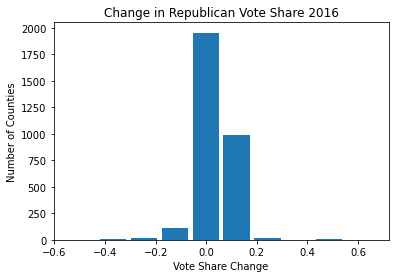

In [16]:
#Plot historgram for the dependent variable for the 2016 election, Change in Republican Vote Share
plt.hist(PresData["Trump_Difference_2016"], rwidth=0.85)
plt.title('Change in Republican Vote Share 2016')
plt.xlabel('Vote Share Change')
plt.ylabel('Number of Counties')
plt.show()


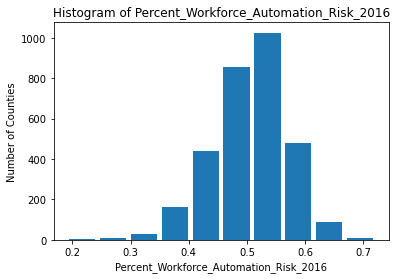

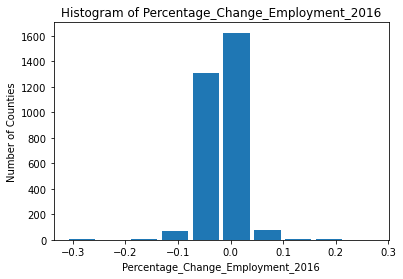

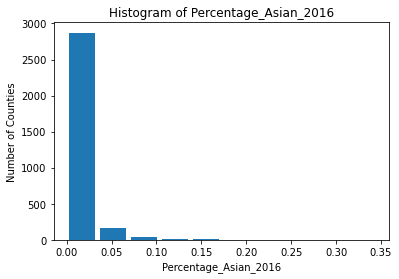

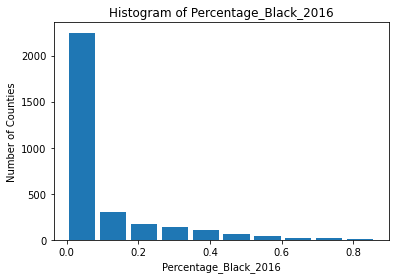

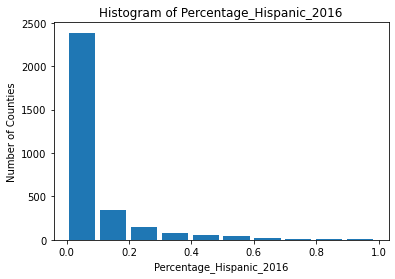

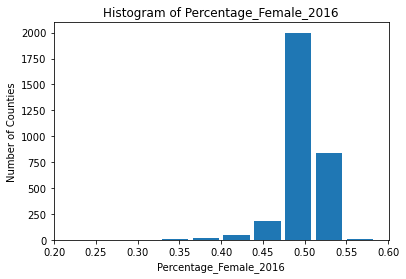

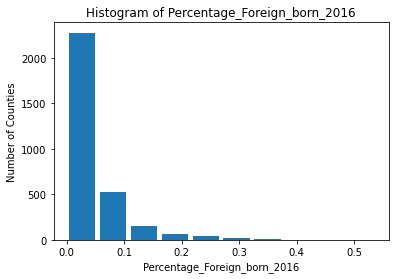

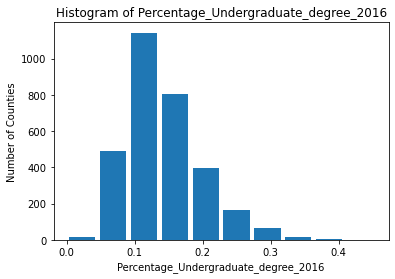

In [17]:
#Plot histograms for the independent variables to be use in the analysis of the 2016 election
for col_name in independent_variables_2016:

    x=PresData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()
    

### Data Manipulation

In [18]:
#Ensure the independent variables are on a uniform scale the scale 

PresData["Change_Vote_Share_2016"] = PresData["Trump_Difference_2016"]*100
PresData["Percentage_Change_Employment_2016_b"] = PresData["Percentage_Change_Employment_2016"]*100
PresData["Percentage_Asian_2016_b"] = PresData["Percentage_Asian_2016"]*100
PresData["Percentage_Black_2016_b"] = PresData["Percentage_Black_2016"]*100
PresData["Percentage_Hispanic_2016_b"] = PresData["Percentage_Hispanic_2016"]*100
PresData["Percentage_Female_2016_b"] = PresData["Percentage_Female_2016"]*100
PresData["Percentage_Foreign_born_2016_b"] = PresData["Percentage_Foreign_born_2016"]*100
PresData["Percentage_Undergraduate_degree_2016_b"] = PresData["Percentage_Undergraduate_degree_2016"]*100

In [19]:
#Prepare relevant independent variables for log transformation

PresData["Percentage_Asian_2016_c"] = PresData["Percentage_Asian_2016_b"]+1
PresData["Percentage_Black_2016_c"] = PresData["Percentage_Black_2016_b"]+1
PresData["Percentage_Hispanic_2016_c"] = PresData["Percentage_Hispanic_2016_b"]+1
PresData["Percentage_Foreign_born_2016_c"] = PresData["Percentage_Foreign_born_2016_b"]+1

In [20]:
#Log transform relevant variables

PresData["log_Percentage_Asian_2016"] = np.log(PresData["Percentage_Asian_2016_c"])
PresData["log_Percentage_Black_2016"] = np.log(PresData["Percentage_Black_2016_c"])
PresData["log_Percentage_Hispanic_2016"] = np.log(PresData["Percentage_Hispanic_2016_c"])
PresData["log_Percentage_Foreign_born_2016"] = np.log(PresData["Percentage_Foreign_born_2016_c"])


In [21]:
#Generate an altered list of variables for 2016
independent_variables_2016_B = ["Percent_Workforce_Automation_Risk_2016",
                                "Percentage_Change_Employment_2016_b",
                                "log_Percentage_Asian_2016",
                                "log_Percentage_Black_2016",
                                "log_Percentage_Hispanic_2016",
                                "Percentage_Female_2016_b",
                                "log_Percentage_Foreign_born_2016",
                                "Percentage_Undergraduate_degree_2016_b"]


### Data Visualisation

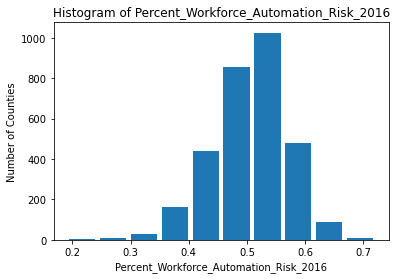

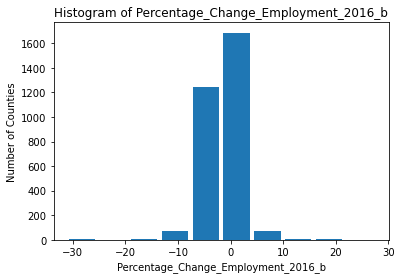

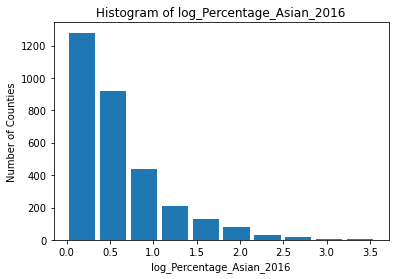

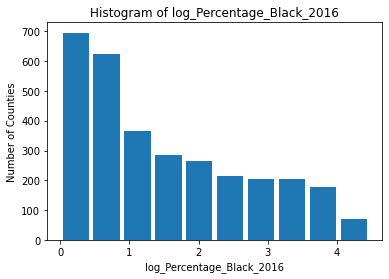

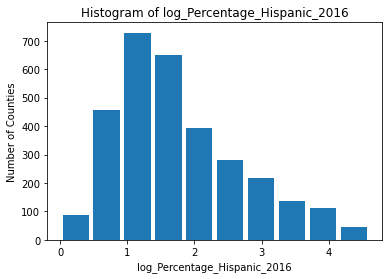

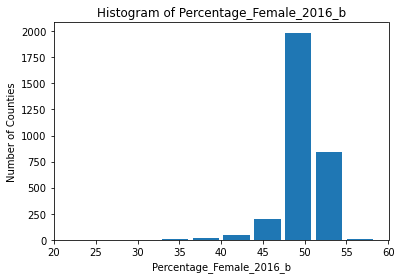

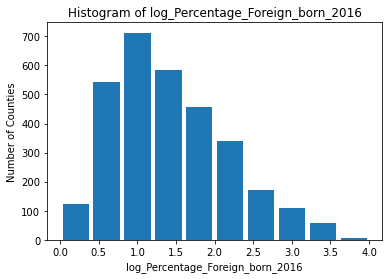

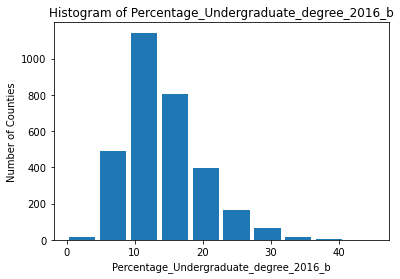

In [22]:
for col_name in independent_variables_2016_B:

    x=PresData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()
    

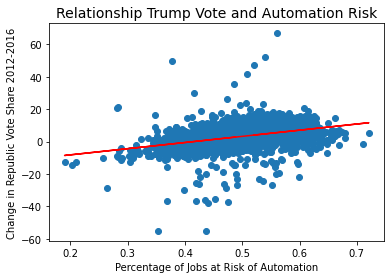

In [23]:
#Generate plot of the change in Republican vote share against the percentage of jobs at risk of automation

x=PresData["Percent_Workforce_Automation_Risk_2016"]
y=PresData["Change_Vote_Share_2016"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x+b, color="red")
plt.title('Relationship Trump Vote and Automation Risk', size=14)
plt.xlabel('Percentage of Jobs at Risk of Automation', size=10)
plt.ylabel('Change in Republic Vote Share 2012-2016', size=10);


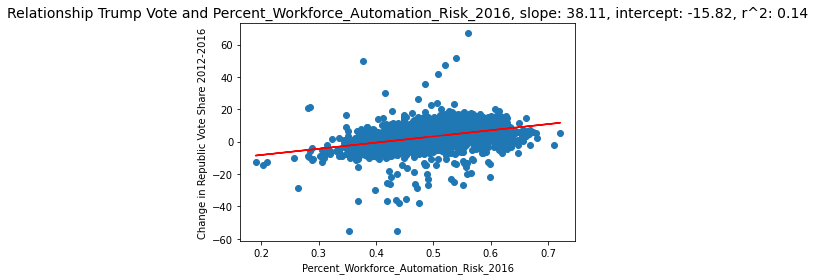

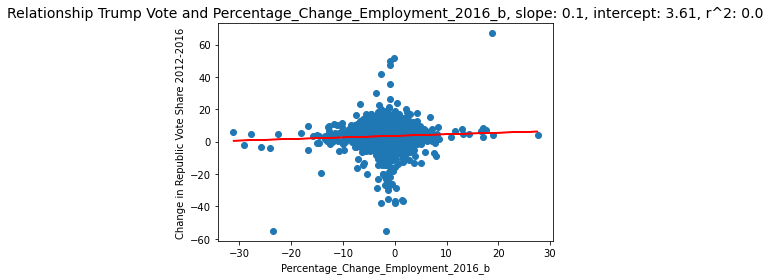

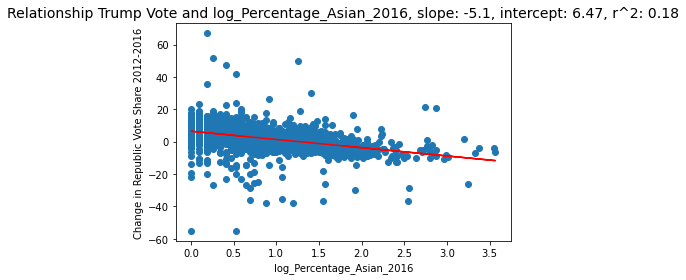

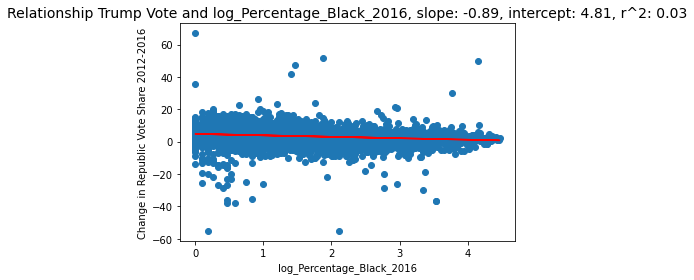

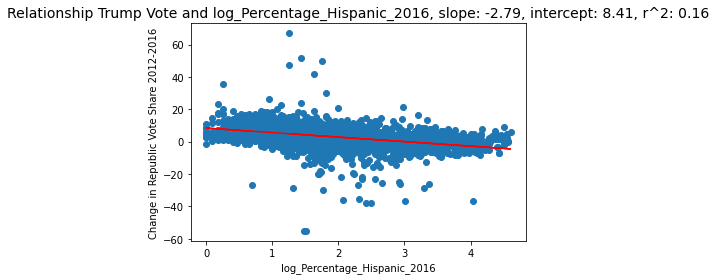

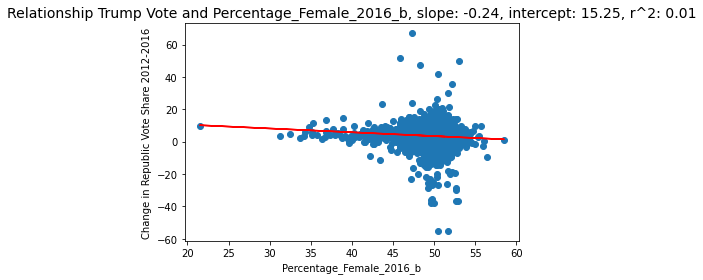

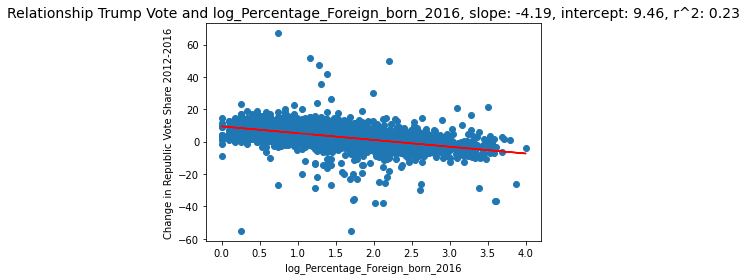

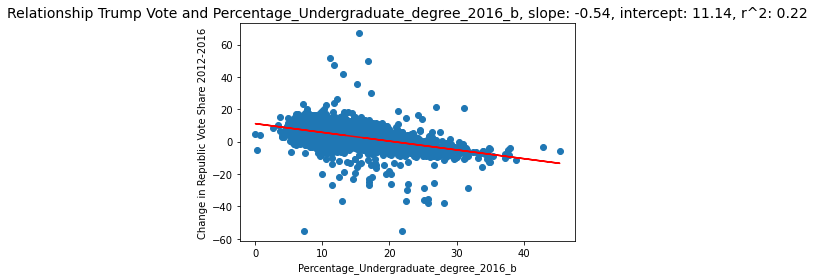

In [24]:
#Generate plots of all independent variables against the change in Republican Vote share in the 2016 Presidential Election 
for col_name in independent_variables_2016_B:
    
    x=PresData[col_name]
    y=PresData["Change_Vote_Share_2016"] 
    m, b = np.polyfit(x, y, 1)
    fittedline=np.poly1d([m,b])
    r2=r2_score(y, fittedline(x))
    plt.plot(x, y, 'o')
    plt.plot(x, m*x+b, color="red")
    plt.title(f'Relationship Trump Vote and {col_name}, slope: {round(m, 2)}, intercept: {round (b, 2)}, r^2: {round(r2, 2)}', size=14)
    plt.xlabel(col_name, size=10)
    plt.ylabel('Change in Republic Vote Share 2012-2016', size=10)
    plt.show()


### Description of Independent Variables

Automation1_2016 contains on column measuring the percentage of a county's workforce in job that are susceptable to automation in 2016.

PopEmploy2_2016 adds labour market controls for the percentage change in population between 2011 and 2015, to account for changes in the size of the labour market, and percentage change in employment over the same period to control for unemployment level. 

Given that votes were reported to have varied considerably, based on demographics, Demograph3_2016 adds controls for the percentage of a county’s population that was Asian, Black, Female, Hispanic or Foreign born in 2015, all of which correlated negatively with support for Trump, per exit poll reporting at the time (Frey et al, 2018).

Education4_2016 adds an education control, specifically the percentage of the population over the age of 
25 who hold a bachelor’s degree or equivalent in 2015.

Finally TrumpVote2016 create the dependent vairable to account for the change in Republican voteshare between the 2012 and 2016 Presidential elections.

In [25]:
#Create tranches of independent variables for the regressions
Automation1_2016 = np.array(PresData["Percent_Workforce_Automation_Risk_2016"]).reshape(-1, 1)

Employment2_2016 = (PresData[["Percent_Workforce_Automation_Risk_2016", 
                             "Percentage_Change_Employment_2016_b"]])

Demograph3_2016 = np.array(PresData[["Percent_Workforce_Automation_Risk_2016",
                                     "Percentage_Change_Employment_2016_b",
                                     "log_Percentage_Asian_2016",
                                     "log_Percentage_Black_2016",
                                     "log_Percentage_Hispanic_2016",
                                     "Percentage_Female_2016_b",
                                     "log_Percentage_Foreign_born_2016"]])

Education4_2016 = np.array(PresData[["Percent_Workforce_Automation_Risk_2016",
                                     "Percentage_Change_Employment_2016_b",
                                     "log_Percentage_Asian_2016",
                                     "log_Percentage_Black_2016",
                                     "log_Percentage_Hispanic_2016",
                                     "Percentage_Female_2016_b",
                                     "log_Percentage_Foreign_born_2016",
                                     "Percentage_Undergraduate_degree_2016_b"]])

#Create dependent variable
TrumpVote2016 = np.array(PresData["Change_Vote_Share_2016"])

### Running the Model

In [31]:
#Regression with no control variables
X = sm.add_constant(Automation1_2016.ravel())
results = sm.OLS(TrumpVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     518.1
Date:                Sun, 01 May 2022   Prob (F-statistic):          3.42e-106
Time:                        22:14:50   Log-Likelihood:                -9994.0
No. Observations:                3107   AIC:                         1.999e+04
Df Residuals:                    3105   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.8183      0.854    -18.530      0.0

In [32]:
#Regression with no employment control
X = sm.add_constant(Employment2_2016)
results = sm.OLS(TrumpVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     265.2
Date:                Sun, 01 May 2022   Prob (F-statistic):          4.54e-107
Time:                        22:15:02   Log-Likelihood:                -9988.6
No. Observations:                3107   AIC:                         1.998e+04
Df Residuals:                    3104   BIC:                         2.000e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [34]:
#Regression with employment and demographic controls
X = sm.add_constant(Demograph3_2016)
results = sm.OLS(TrumpVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     216.3
Date:                Sun, 01 May 2022   Prob (F-statistic):          3.86e-262
Time:                        22:15:14   Log-Likelihood:                -9615.8
No. Observations:                3107   AIC:                         1.925e+04
Df Residuals:                    3099   BIC:                         1.930e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6593      2.286      4.225      0.0

In [35]:
#Regression with employment, demograpic, and education controls
X = sm.add_constant(Education4_2016)
results = sm.OLS(TrumpVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     235.5
Date:                Sun, 01 May 2022   Prob (F-statistic):          8.81e-313
Time:                        22:15:15   Log-Likelihood:                -9495.7
No. Observations:                3107   AIC:                         1.901e+04
Df Residuals:                    3098   BIC:                         1.906e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.2284      2.282      8.425      0.0

## Part 2 of analysis: The 2020 Presidential Election

### Data Manipulation

In [36]:
#Construct column "Change_Vote_Share_2016" so as to work in percentages when analysing the 2016 Presidental Election
PresData["Change_Vote_Share_2020"] = PresData["Trump_Difference_2020"]*100

#Check it worked
PresData["Change_Vote_Share_2020"]

0      -1.330
1      -0.374
2       1.355
3       2.023
4       0.237
        ...  
3102    2.704
3103   -1.476
3104    7.071
3105    4.558
3106    1.701
Name: Change_Vote_Share_2020, Length: 3107, dtype: float64

#### NB: The American Communities Survey did not carry out sample census in the United States in 2020 due to the COVID-19 pandemic. Data 2019 ACS is used as a proxy in it's stead.

In [37]:
#Generate a list of independent variables for the 2020 Presidiental Election
independent_variables_2019 = ["Percent_Workforce_Automation_Risk_2019", 
                              "Percentage_Population_Difference_2019",
                              "Percentage_Change_Employment_2019",
                              "Percentage_Asian_2019",
                              "Percentage_Black_2019",
                              "Percentage_Hispanic_2019",
                              "Percentage_Female_2019",
                              "Percentage_Foreign_born_2019",
                              "Percentage_Undergraduate_degree_2019"]

#Confirm characterisitics of "independent_variables_2019"
type(independent_variables_2019), len(independent_variables_2019), type(independent_variables_2019[0])

(list, 9, str)

In [38]:
#Print the column names in the independent_variables_2019 list
for col_name in independent_variables_2019:
    print(col_name)

Percent_Workforce_Automation_Risk_2019
Percentage_Population_Difference_2019
Percentage_Change_Employment_2019
Percentage_Asian_2019
Percentage_Black_2019
Percentage_Hispanic_2019
Percentage_Female_2019
Percentage_Foreign_born_2019
Percentage_Undergraduate_degree_2019


### Data Visualisation

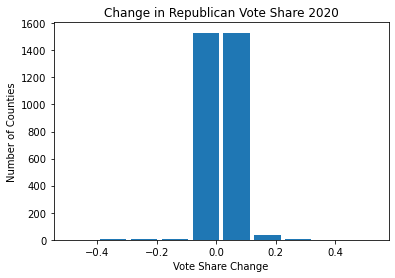

In [39]:
#Plot historgram for the dependent variable for the 2020 election, Change in Republican Vote Share
plt.hist(PresData["Trump_Difference_2020"], rwidth=0.85)
plt.title('Change in Republican Vote Share 2020')
plt.xlabel('Vote Share Change')
plt.ylabel('Number of Counties')
plt.show()

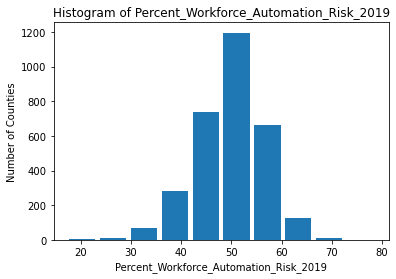

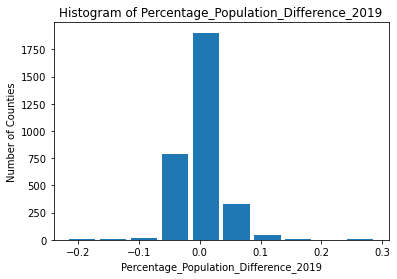

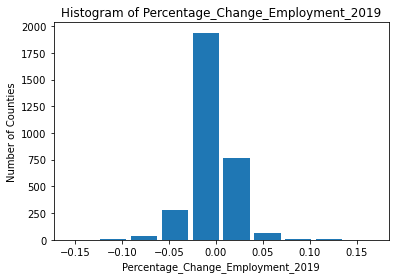

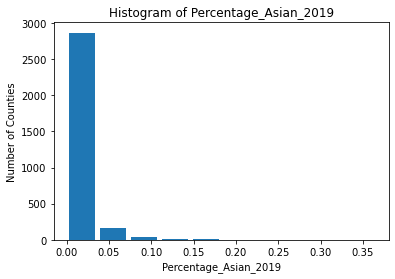

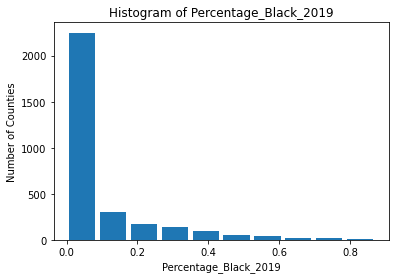

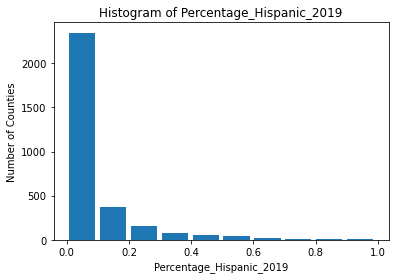

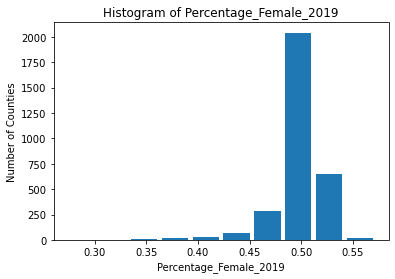

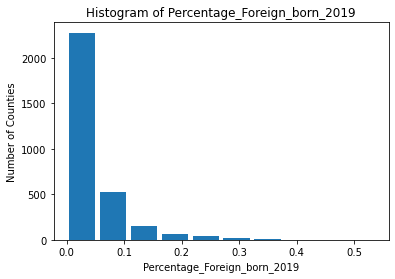

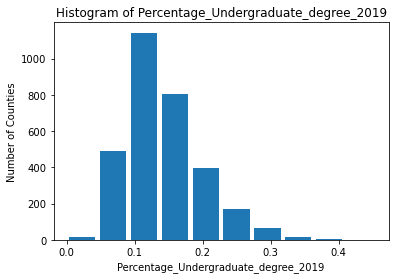

In [40]:
#Plot histograms for the independent variables to be use in the analysis of the 2020 election
for col_name in independent_variables_2019:

    x=PresData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()


### Data Manipulation

In [41]:
#Ensure the variables are on a uniform scale the scale 

PresData["Change_Vote_Share_2020"] = PresData["Trump_Difference_2020"]*100
PresData["Percentage_Population_Difference_2019_b"] = PresData["Percentage_Population_Difference_2019"]*100
PresData["Percentage_Change_Employment_2019_b"] = PresData["Percentage_Change_Employment_2019"]*100
PresData["Percentage_Asian_2019_b"] = PresData["Percentage_Asian_2019"]*100
PresData["Percentage_Black_2019_b"] = PresData["Percentage_Black_2019"]*100
PresData["Percentage_Hispanic_2019_b"] = PresData["Percentage_Hispanic_2019"]*100
PresData["Percentage_Female_2019_b"] = PresData["Percentage_Female_2019"]*100
PresData["Percentage_Foreign_born_2019_b"] = PresData["Percentage_Foreign_born_2019"]*100
PresData["Percentage_Undergraduate_degree_2019_b"] = PresData["Percentage_Undergraduate_degree_2019"]*100

In [42]:
#Prepare relevant independent variables for log transformation

PresData["Percentage_Asian_2019_c"] = PresData["Percentage_Asian_2019_b"]+1
PresData["Percentage_Black_2019_c"] = PresData["Percentage_Black_2019_b"]+1
PresData["Percentage_Hispanic_2019_c"] = PresData["Percentage_Hispanic_2019_b"]+1
PresData["Percentage_Foreign_born_2019_c"] = PresData["Percentage_Foreign_born_2019_b"]+1

In [43]:
#Log transform relevant variables

PresData["log_Percentage_Asian_2019"] = np.log(PresData["Percentage_Asian_2019_c"])
PresData["log_Percentage_Black_2019"] = np.log(PresData["Percentage_Black_2019_c"])
PresData["log_Percentage_Hispanic_2019"] = np.log(PresData["Percentage_Hispanic_2019_c"])
PresData["log_Percentage_Foreign_born_2019"] = np.log(PresData["Percentage_Foreign_born_2019_c"])


In [44]:
#Generate an altered list of variables for 2019
independent_variables_2019_B = ["Percent_Workforce_Automation_Risk_2019",
                                "Percentage_Population_Difference_2019_b",
                                "Percentage_Change_Employment_2019_b",
                                "log_Percentage_Asian_2019",
                                "log_Percentage_Black_2019",
                                "log_Percentage_Hispanic_2019",
                                "Percentage_Female_2019_b",
                                "log_Percentage_Foreign_born_2019",
                                "Percentage_Undergraduate_degree_2019_b"]


### Data Visualisation

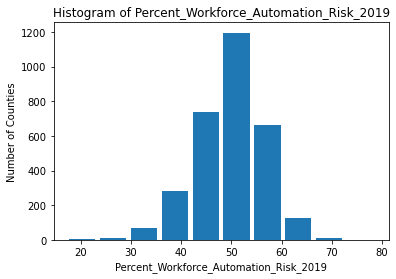

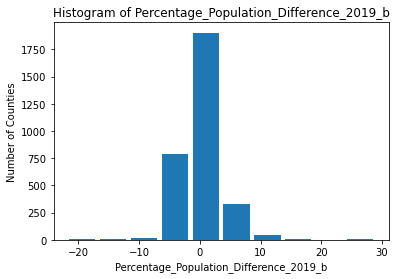

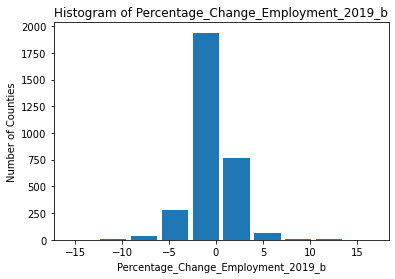

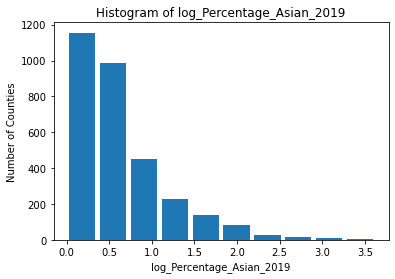

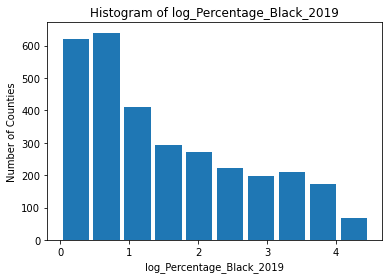

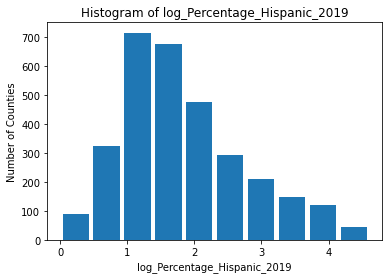

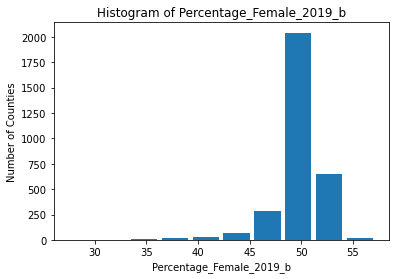

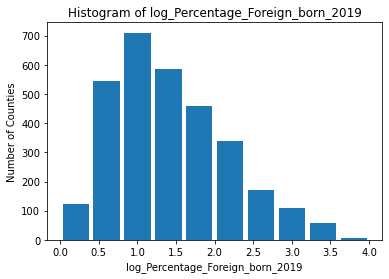

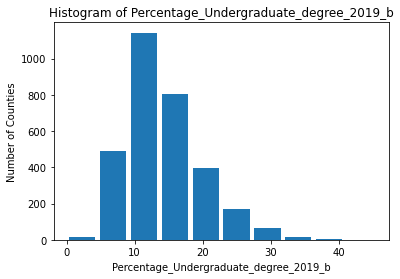

In [45]:
#Visualise the modified variables
for col_name in independent_variables_2019_B:

    x=PresData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()

Text(0, 0.5, 'Change in Republic Vote Share 2016-2020')

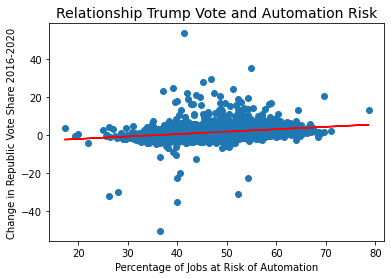

In [46]:
#Generate plot of the change in Republican vote share against the percentage of jobs at risk of automation

x=PresData["Percent_Workforce_Automation_Risk_2019"]
y=PresData["Change_Vote_Share_2020"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x+b, color="red")
plt.title('Relationship Trump Vote and Automation Risk', size=14)
plt.xlabel('Percentage of Jobs at Risk of Automation', size=10)
plt.ylabel('Change in Republic Vote Share 2016-2020', size=10)

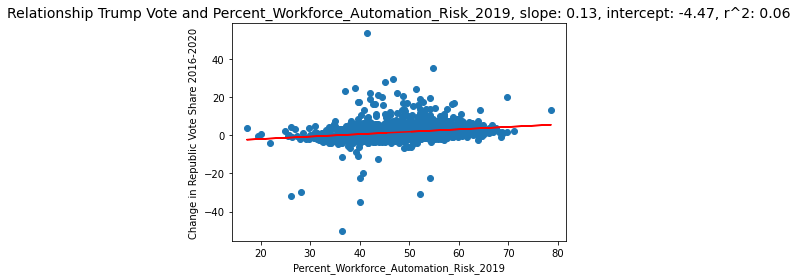

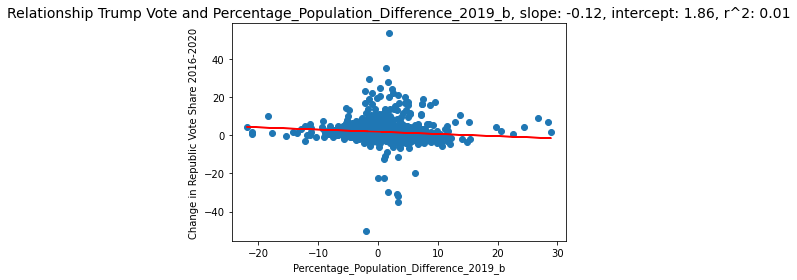

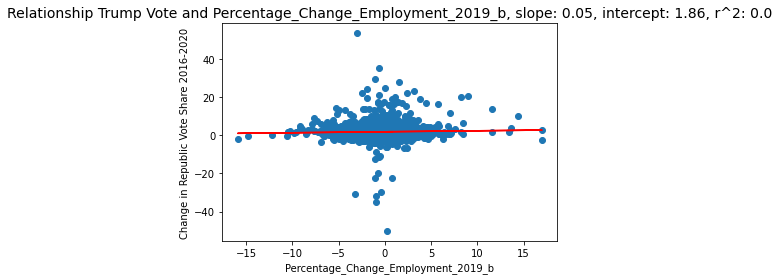

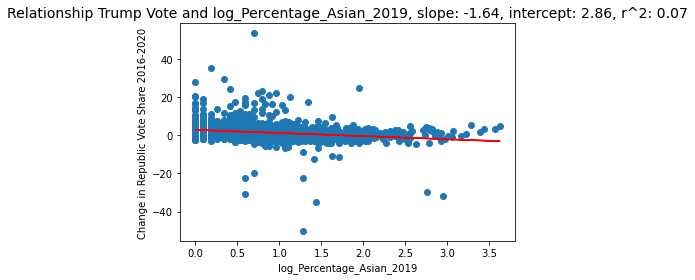

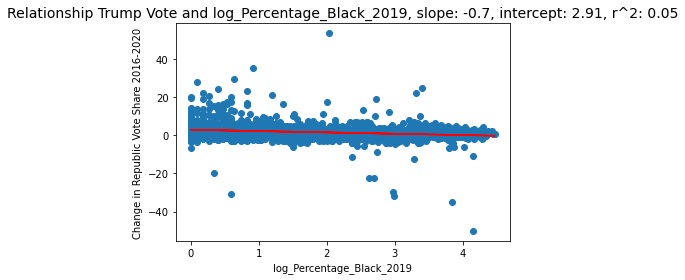

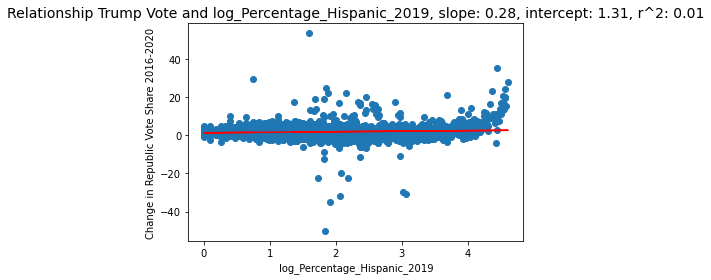

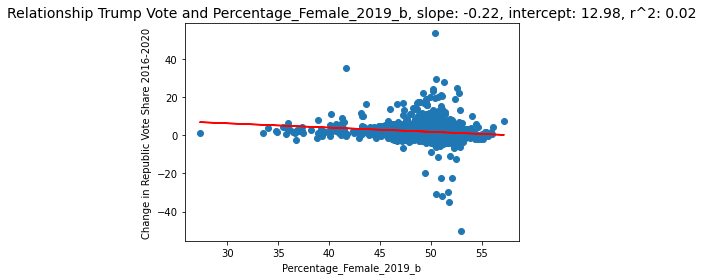

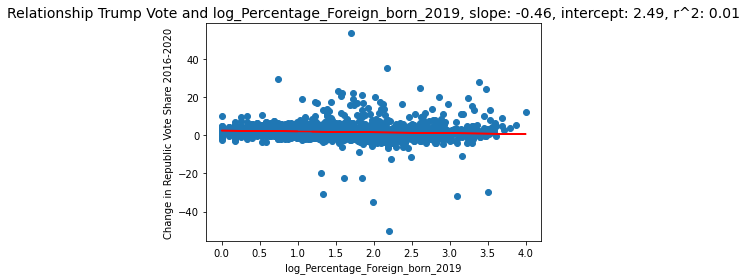

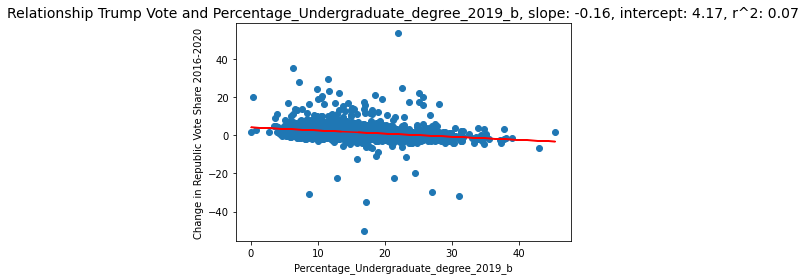

In [47]:
#Generate plots of all independent variables against the change in Republican Vote share in the 2020 Presidential Election 
for col_name in independent_variables_2019_B:
    
    x=PresData[col_name]
    y=PresData["Change_Vote_Share_2020"] 
    m, b = np.polyfit(x, y, 1)
    fittedline=np.poly1d([m,b])
    r2=r2_score(y, fittedline(x))
    plt.plot(x, y, 'o')
    plt.plot(x, m*x+b, color="red")
    plt.title(f'Relationship Trump Vote and {col_name}, slope: {round(m, 2)}, intercept: {round (b, 2)}, r^2: {round(r2, 2)}', size=14)
    plt.xlabel(col_name, size=10)
    plt.ylabel('Change in Republic Vote Share 2016-2020', size=10)
    plt.show()

### Description of Independent Variables

Automation1_2019 contains on column measuring the percentage of a county's workforce in job that were susceptable to automation in 2019.

PopEmploy2_2019 adds labour market controls for the percentage change in population between 2015 and 2019, to account for changes in the size of the labour market, and percentage change in employment over the same period to control for unemployment level. 

Given that votes were reported to have varied considerably, based on demographics, Demograph3_2019 adds controls for the percentage of a county’s population that was Asian, Black, Female, Foreign born in 2019, all of which correlated negatively with support for Trump, per exit poll reporting at the time (Frey et al, 2018). The percentage of the country's population that is Hispanic in 2019 is included for consistency with the 2016 analysis despite correlating positively with support for Trump.

Education4_2019 adds an education control, specifically the percentage of the population over the age of 
25 who hold a bachelor’s degree or equivalent in 2019.

Finally TrumpVote2020 create the dependent vairable to account for the change in Republican voteshare between the 2016 and 2020 Presidential elections.

In [99]:
#Create dependent variable
TrumpVote2020 = np.array(PresData["Change_Vote_Share_2020"])

#Create tranches of independent variables for the regressions
Automation1_2019 = np.array(PresData["Percent_Workforce_Automation_Risk_2019"]).reshape(-1, 1)

PopEmploy2_2019 = (PresData[["Percent_Workforce_Automation_Risk_2019",
                             "Percentage_Population_Difference_2019_b",
                             "Percentage_Change_Employment_2019_b"]])

Demograph3_2019 = np.array(PresData[["Percent_Workforce_Automation_Risk_2019",
                                     "Percentage_Population_Difference_2019_b",
                                     "Percentage_Change_Employment_2019_b",
                                     "log_Percentage_Asian_2019",
                                     "log_Percentage_Black_2019",
                                     "log_Percentage_Hispanic_2019",
                                     "Percentage_Female_2016_b",
                                     "log_Percentage_Foreign_born_2019"]])

Education4_2019 = np.array(PresData[["Percent_Workforce_Automation_Risk_2019",
                                     "Percentage_Population_Difference_2019_b",
                                     "Percentage_Change_Employment_2019_b",
                                     "log_Percentage_Asian_2019",
                                     "log_Percentage_Black_2019",
                                     "log_Percentage_Hispanic_2019",
                                     "Percentage_Female_2019_b",
                                     "log_Percentage_Foreign_born_2019",
                                     "Percentage_Undergraduate_degree_2019_b"]])

#Create dependent variable
TrumpVote2016 = np.array(PresData["Change_Vote_Share_2016"])

### Running the Model

In [58]:
#Regression with no control variables
X = sm.add_constant(Automation1_2019.ravel())
results = sm.OLS(TrumpVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     190.0
Date:                Sun, 01 May 2022   Prob (F-statistic):           5.45e-42
Time:                        22:21:29   Log-Likelihood:                -8250.6
No. Observations:                3107   AIC:                         1.651e+04
Df Residuals:                    3105   BIC:                         1.652e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4734      0.462     -9.682      0.0

In [60]:
#Regression with employment controls
X = sm.add_constant(PopEmploy2_2019)
results = sm.OLS(TrumpVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     70.07
Date:                Sun, 01 May 2022   Prob (F-statistic):           7.71e-44
Time:                        22:21:36   Log-Likelihood:                -8241.0
No. Observations:                3107   AIC:                         1.649e+04
Df Residuals:                    3103   BIC:                         1.651e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [61]:
X = sm.add_constant(Demograph3_2019)
results = sm.OLS(TrumpVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     72.03
Date:                Sun, 01 May 2022   Prob (F-statistic):          4.21e-109
Time:                        22:21:41   Log-Likelihood:                -8077.8
No. Observations:                3107   AIC:                         1.617e+04
Df Residuals:                    3098   BIC:                         1.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9906      1.390      2.871      0.0

In [62]:
X = sm.add_constant(Education4_2019)
results = sm.OLS(TrumpVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     68.46
Date:                Sun, 01 May 2022   Prob (F-statistic):          2.29e-115
Time:                        22:21:44   Log-Likelihood:                -8061.0
No. Observations:                3107   AIC:                         1.614e+04
Df Residuals:                    3097   BIC:                         1.620e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4702      1.459      4.436      0.0

## Part 3 of analysis: The 2020 Democratic Primary

### Data Manipulation

In [63]:
#Construct column "Change_Vote_Share_2016" so as to work in percentages when analysing the 2016 Presidental Election
PrimData["Change_Vote_Share_2020"] = PrimData["Sanders_Difference_2020"]*100

#Check it worked
PrimData["Change_Vote_Share_2020"]

<ipython-input-63-6600d9643bb2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["Change_Vote_Share_2020"] = PrimData["Sanders_Difference_2020"]*100


0       -1.22326
1      -13.25861
2        0.15976
3       -5.87001
4      -12.41038
          ...   
2841   -29.91100
2842   -30.33214
2843   -33.19792
2844   -12.57310
2845   -20.00000
Name: Change_Vote_Share_2020, Length: 2846, dtype: float64

### Data Visualisation

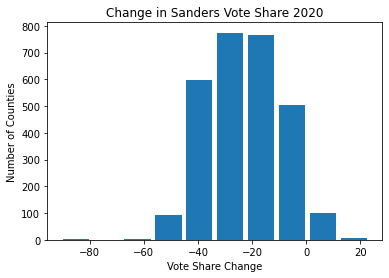

In [107]:
#Plot historgram for the dependent variable for the 2020 Democratic Primary, Change in Sander' Vote Share
plt.hist(PrimData["Change_Vote_Share_2020"], rwidth=0.85)
plt.title('Change in Sanders Vote Share 2020')
plt.xlabel('Vote Share Change')
plt.ylabel('Number of Counties')
plt.show()

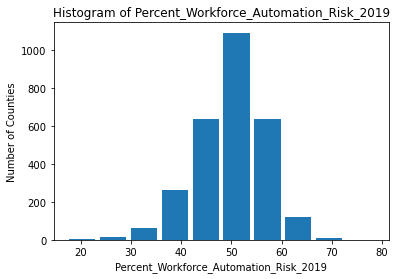

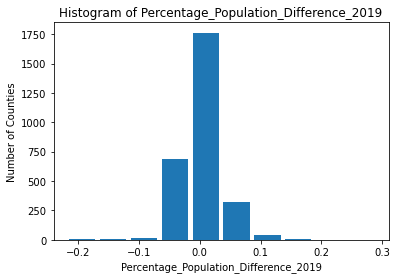

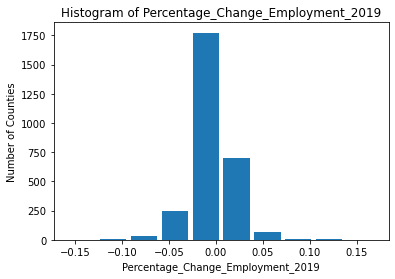

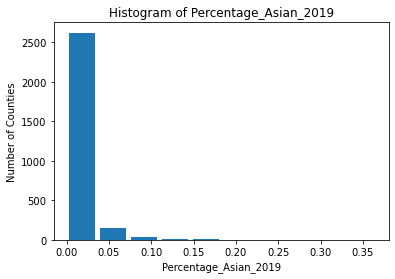

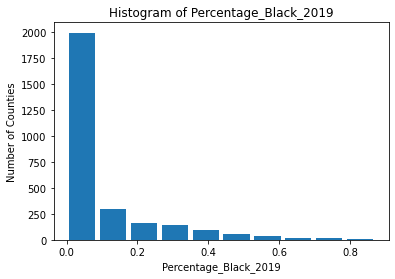

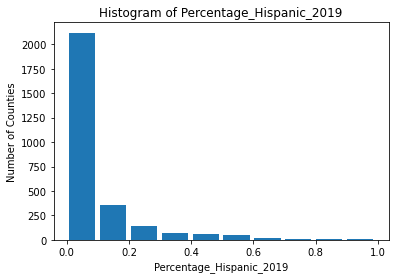

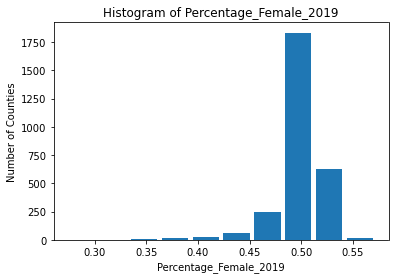

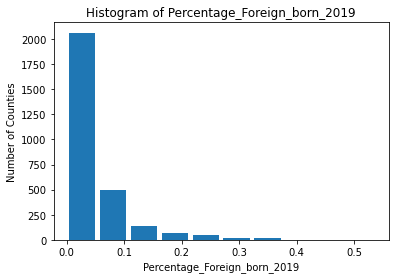

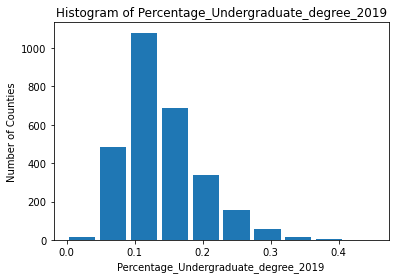

In [65]:
#Plot histograms for the independent variables to be use in the analysis of the 2020 Democratic Primary
for col_name in independent_variables_2019:

    x=PrimData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()


In [68]:
#Ensure the variables are on a uniform scale the scale 

PrimData["Percentage_Population_Difference_2019_b"] = PrimData["Percentage_Population_Difference_2019"]*100
PrimData["Percentage_Change_Employment_2019_b"] = PrimData["Percentage_Change_Employment_2019"]*100
PrimData["Percentage_Asian_2019_b"] = PrimData["Percentage_Asian_2019"]*100
PrimData["Percentage_Black_2019_b"] = PrimData["Percentage_Black_2019"]*100
PrimData["Percentage_Hispanic_2019_b"] = PrimData["Percentage_Hispanic_2019"]*100
PrimData["Percentage_Female_2019_b"] = PrimData["Percentage_Female_2019"]*100
PrimData["Percentage_Foreign_born_2019_b"] = PrimData["Percentage_Foreign_born_2019"]*100
PrimData["Percentage_Undergraduate_degree_2019_b"] = PrimData["Percentage_Undergraduate_degree_2019"]*100


<ipython-input-68-ed3ee8a7bb4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["Percentage_Population_Difference_2019_b"] = PrimData["Percentage_Population_Difference_2019"]*100
<ipython-input-68-ed3ee8a7bb4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["Percentage_Change_Employment_2019_b"] = PrimData["Percentage_Change_Employment_2019"]*100
<ipython-input-68-ed3ee8a7bb4e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [69]:
#Prepare relevant independent variables for log transformation

PrimData["Percentage_Asian_2019_c"] = PrimData["Percentage_Asian_2019_b"]+1
PrimData["Percentage_Black_2019_c"] = PrimData["Percentage_Black_2019_b"]+1
PrimData["Percentage_Hispanic_2019_c"] = PrimData["Percentage_Hispanic_2019_b"]+1
PrimData["Percentage_Foreign_born_2019_c"] = PrimData["Percentage_Foreign_born_2019_b"]+1

<ipython-input-69-62def562139d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["Percentage_Asian_2019_c"] = PrimData["Percentage_Asian_2019_b"]+1
<ipython-input-69-62def562139d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["Percentage_Black_2019_c"] = PrimData["Percentage_Black_2019_b"]+1
<ipython-input-69-62def562139d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [70]:
#Log transform relevant variables

PrimData["log_Percentage_Asian_2019"] = np.log(PrimData["Percentage_Asian_2019_c"])
PrimData["log_Percentage_Black_2019"] = np.log(PrimData["Percentage_Black_2019_c"])
PrimData["log_Percentage_Hispanic_2019"] = np.log(PrimData["Percentage_Hispanic_2019_c"])
PrimData["log_Percentage_Foreign_born_2019"] = np.log(PrimData["Percentage_Foreign_born_2019_c"])


<ipython-input-70-9c5333d181ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["log_Percentage_Asian_2019"] = np.log(PrimData["Percentage_Asian_2019_c"])
<ipython-input-70-9c5333d181ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrimData["log_Percentage_Black_2019"] = np.log(PrimData["Percentage_Black_2019_c"])
<ipython-input-70-9c5333d181ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [71]:
#Generate an altered list of variables for 2019
independent_variables_2019_B = ["Percent_Workforce_Automation_Risk_2019",
                                "Percentage_Population_Difference_2019_b",
                                "Percentage_Change_Employment_2019_b",
                                "log_Percentage_Asian_2019",
                                "log_Percentage_Black_2019",
                                "log_Percentage_Hispanic_2019",
                                "Percentage_Female_2019_b",
                                "log_Percentage_Foreign_born_2019",
                                "Percentage_Undergraduate_degree_2019_b"]


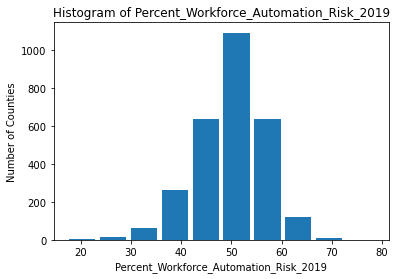

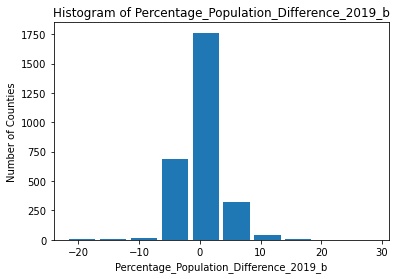

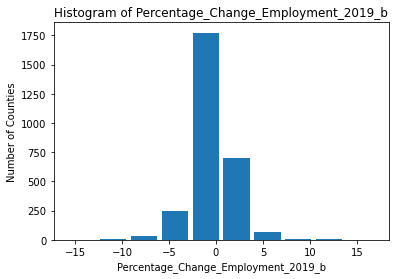

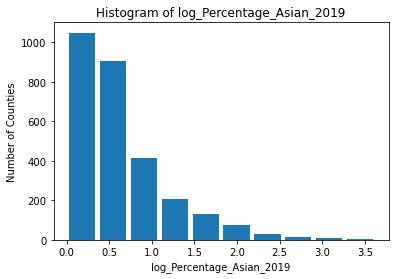

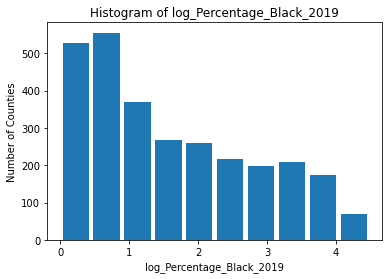

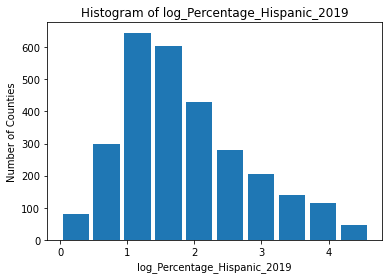

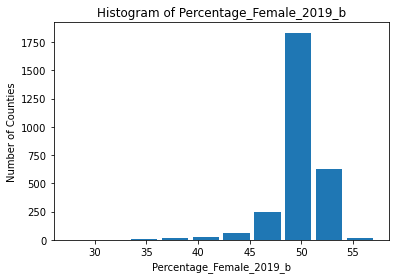

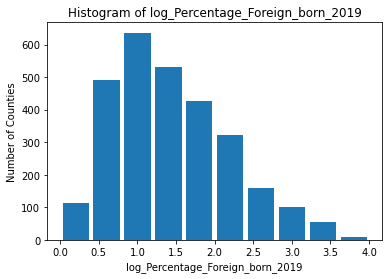

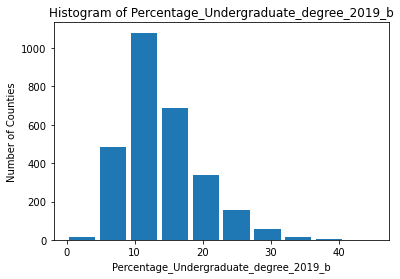

In [72]:
#Visualise the modified variables
for col_name in independent_variables_2019_B:

    x=PrimData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()

Text(0, 0.5, 'Change in Sanders Vote Share 2016-2020')

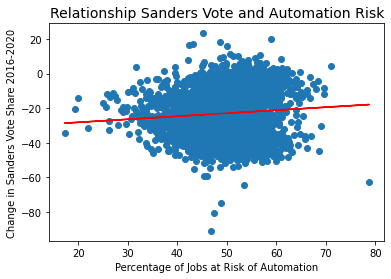

In [188]:
#Generate plot of the change in Sanders' vote share against the percentage of jobs at risk of automation

x=PrimData["Percent_Workforce_Automation_Risk_2019"]
y=PrimData["Change_Vote_Share_2020"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x+b, color="red")
plt.title('Relationship Sanders Vote and Automation Risk', size=14)
plt.xlabel('Percentage of Jobs at Risk of Automation', size=10)
plt.ylabel('Change in Sanders Vote Share 2016-2020', size=10)

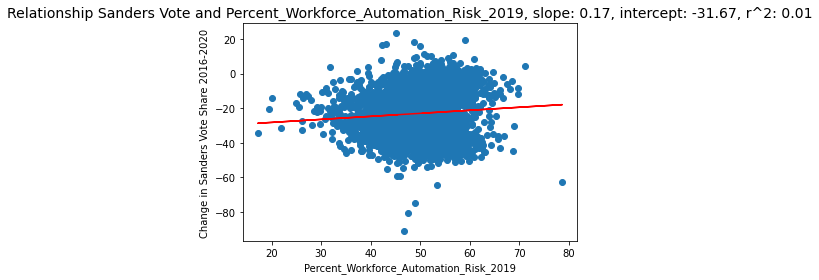

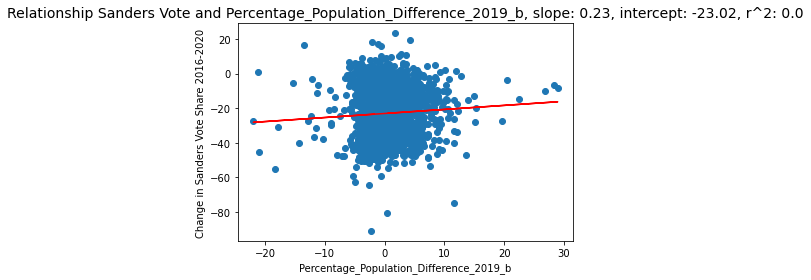

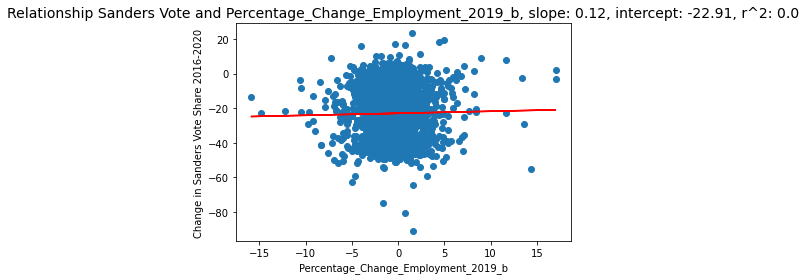

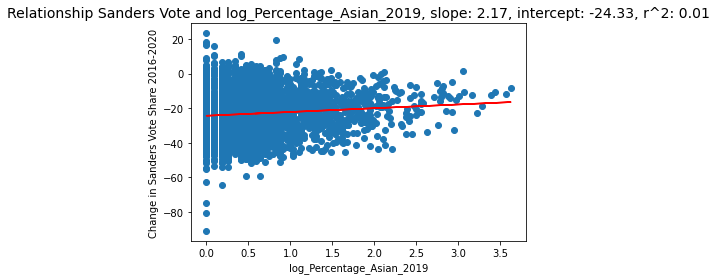

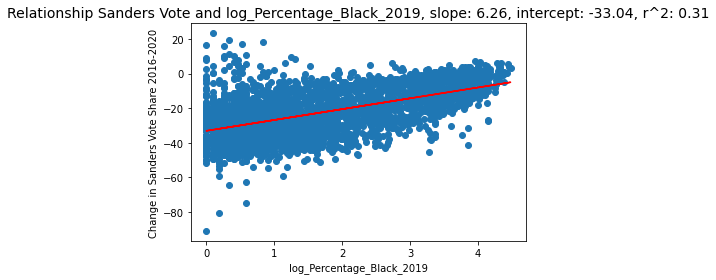

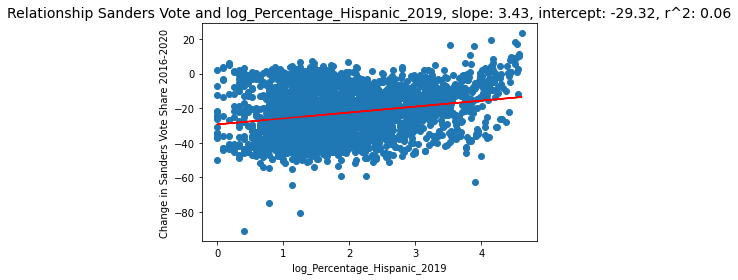

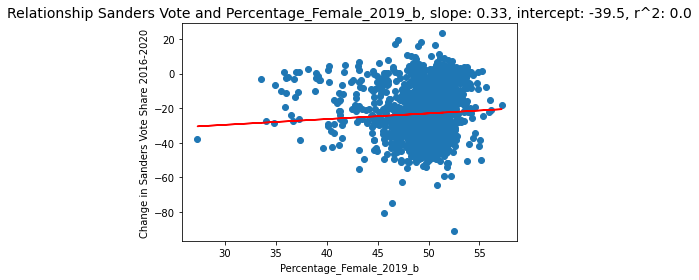

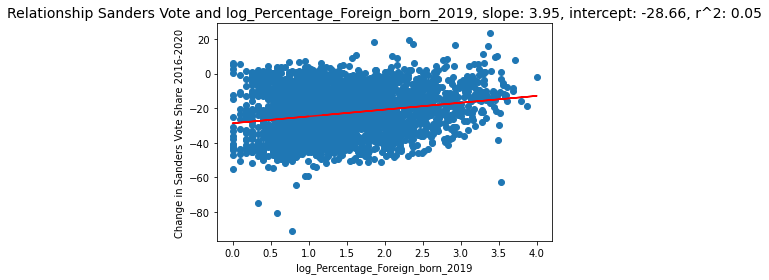

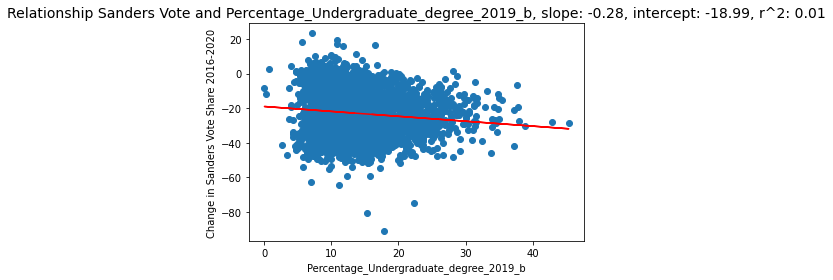

In [73]:
#Generate plots of all independent variables against the change in Republican Vote share in the 2016 Presidential Election 
for col_name in independent_variables_2019_B:
    
    x=PrimData[col_name]
    y=PrimData["Change_Vote_Share_2020"] 
    m, b = np.polyfit(x, y, 1)
    fittedline=np.poly1d([m,b])
    r2=r2_score(y, fittedline(x))
    plt.plot(x, y, 'o')
    plt.plot(x, m*x+b, color="red")
    plt.title(f'Relationship Sanders Vote and {col_name}, slope: {round(m, 2)}, intercept: {round (b, 2)}, r^2: {round(r2, 2)}', size=14)
    plt.xlabel(col_name, size=10)
    plt.ylabel('Change in Sanders Vote Share 2016-2020', size=10)
    plt.show()

### Description of Independent Variables

Automation1_2019 contains on column measuring the percentage of a county's workforce in job that were susceptable to automation in 2019.

PopEmploy2_2019 adds labour market controls for the percentage change in population between 2015 and 2019, to account for changes in the size of the labour market, and percentage change in employment over the same period to control for unemployment level. 

Given that votes were reported to have varied considerably, based on demographics, Demograph3_2019 adds controls for the percentage of a county’s population that was Asian, Black, Female, Foreign born in 2019, all of which correlated negatively with support for Trump, per exit poll reporting at the time (Frey et al, 2018). The percentage of the country's population that is Hispanic in 2019 is included for consistency with the 2016 analysis despite correlating positively with support for Trump.

Education4_2019 adds an education control, specifically the percentage of the population over the age of 
25 who hold a bachelor’s degree or equivalent in 2019.

Finally SandersVote2020 create the dependent vairable to account for the change in Republican voteshare between the 2016 and 2020 Presidential elections.

In [75]:
#Create tranches of independent variables for the regressions
Automation1_2019 = np.array(PrimData["Percent_Workforce_Automation_Risk_2019"]).reshape(-1, 1)

PopEmploy2_2019 = (PrimData[["Percent_Workforce_Automation_Risk_2019",
                             "Percentage_Population_Difference_2019",
                             "Percentage_Change_Employment_2019"]])

Demograph3_2019 = np.array(PrimData[["Percent_Workforce_Automation_Risk_2019",
                                     "Percentage_Population_Difference_2019",
                                     "Percentage_Change_Employment_2019",
                                     "Percentage_Asian_2019",
                                     "Percentage_Black_2019",
                                     "Percentage_Hispanic_2019",
                                     "Percentage_Female_2019",
                                     "Percentage_Foreign_born_2019"]])

Education4_2019 = np.array(PrimData[["Percent_Workforce_Automation_Risk_2019",
                                     "Percentage_Population_Difference_2019",
                                     "Percentage_Change_Employment_2019",
                                     "Percentage_Asian_2019",
                                     "Percentage_Black_2019",
                                     "Percentage_Hispanic_2019",
                                     "Percentage_Female_2019",
                                     "Percentage_Foreign_born_2019",
                                     "Percentage_Undergraduate_degree_2019"]])

#Create dependent variable
SandersVote2020 = np.array(PrimData["Change_Vote_Share_2020"])

### Running the Model

In [76]:
#Regression with no control variables
X = sm.add_constant(Automation1_2019.ravel())
results = sm.OLS(SandersVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     21.76
Date:                Sun, 01 May 2022   Prob (F-statistic):           3.24e-06
Time:                        22:34:12   Log-Likelihood:                -11469.
No. Observations:                2846   AIC:                         2.294e+04
Df Residuals:                    2844   BIC:                         2.295e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.6693      1.885    -16.797      0.0

In [79]:
#Regression with employment controls
X = sm.add_constant(PopEmploy2_2019)
results = sm.OLS(SandersVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     13.03
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.89e-08
Time:                        22:34:36   Log-Likelihood:                -11461.
No. Observations:                2846   AIC:                         2.293e+04
Df Residuals:                    2842   BIC:                         2.295e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [80]:
#Regression with employment and demograpic controls
X = sm.add_constant(Demograph3_2019)
results = sm.OLS(SandersVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     269.5
Date:                Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                        22:34:36   Log-Likelihood:                -10676.
No. Observations:                2846   AIC:                         2.137e+04
Df Residuals:                    2837   BIC:                         2.142e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.0964      4.482    -12.292      0.0

In [81]:
#Regression with employment, demograpic, and education controls
X = sm.add_constant(Education4_2019)
results = sm.OLS(SandersVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     241.4
Date:                Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                        22:34:36   Log-Likelihood:                -10671.
No. Observations:                2846   AIC:                         2.136e+04
Df Residuals:                    2836   BIC:                         2.142e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.7680      4.681    -10.847      0.0

## Appendix: Analysis of the Biden and Clinton Presidental Vote 

## Clinton 2016

### Data Manipulation

Since the independent variables are identical to those used  in the Trump 2016 analysis, there is only a need to construct a dependent variable.

In [82]:
#Construct column "Change_Vote_Share_2016" so as to work in percentages when analysing the 2016 Presidental Election
PresData["Clinton_Vote_Change_2016"] = PresData["Clinton_2016"]*100

#Check it worked
PresData["Clinton_Vote_Change_2016"]

0      -2.77
1      -2.17
2      -4.80
3      -4.90
4      -3.92
        ... 
3102   -9.40
3103    3.73
3104   -4.87
3105   -6.18
3106   -4.08
Name: Clinton_Vote_Change_2016, Length: 3107, dtype: float64

### Data Visualisation

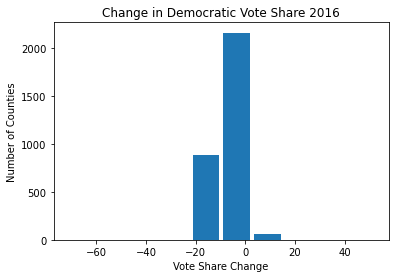

In [83]:
#Plot historgram for the dependent variable for the 2016 election, Change in Republican Vote Share
plt.hist(PresData["Clinton_Vote_Change_2016"], rwidth=0.85)
plt.title('Change in Democratic Vote Share 2016')
plt.xlabel('Vote Share Change')
plt.ylabel('Number of Counties')
plt.show()

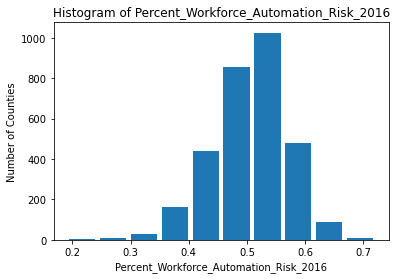

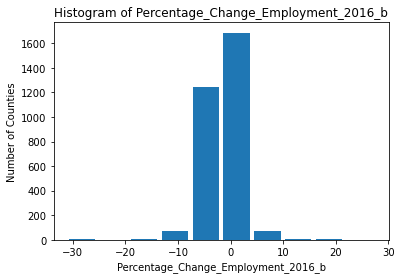

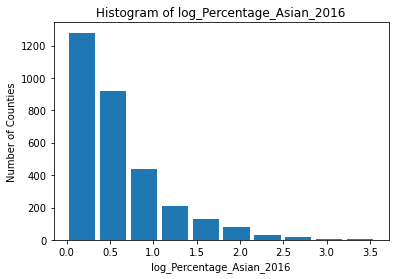

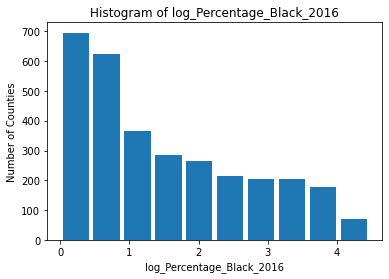

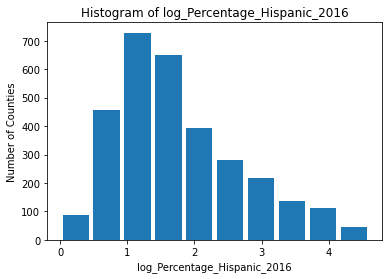

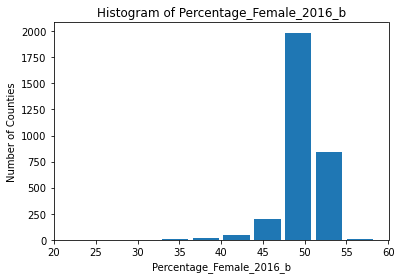

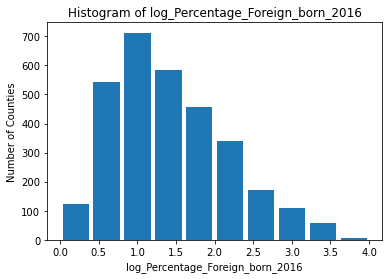

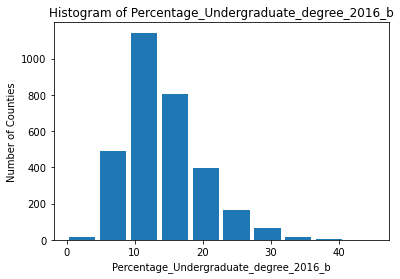

In [84]:
#Plot histograms for the independent variables to be use in the analysis of the 2016 election
for col_name in independent_variables_2016_B:

    x=PresData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()

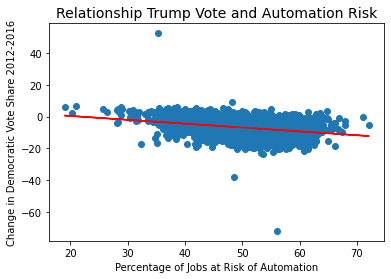

In [258]:
#Generate plot of the change in Democratic vote share against the percentage of jobs at risk of automation

x=PresData["Percent_Workforce_Automation_Risk_2016"]
y=PresData["Clinton_Vote_Change_2016"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x+b, color="red")
plt.title('Relationship Trump Vote and Automation Risk', size=14)
plt.xlabel('Percentage of Jobs at Risk of Automation', size=10)
plt.ylabel('Change in Democratic Vote Share 2012-2016', size=10);

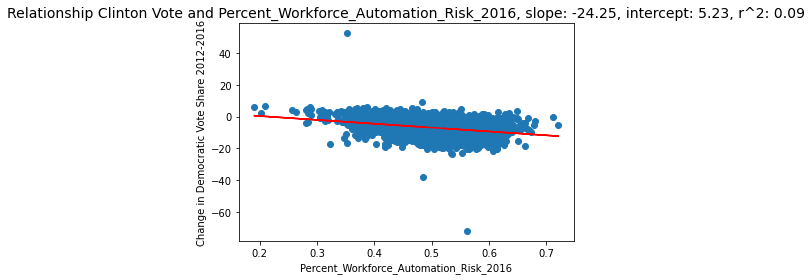

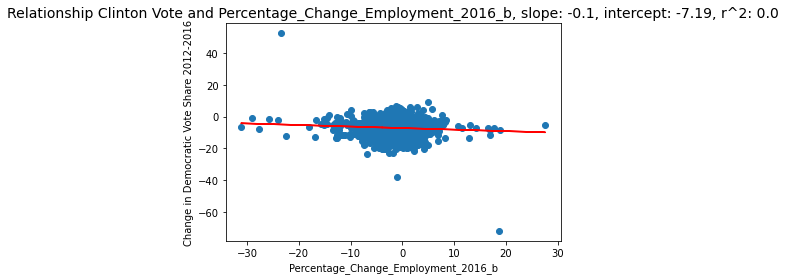

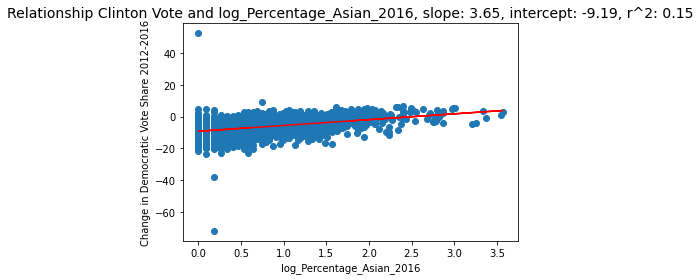

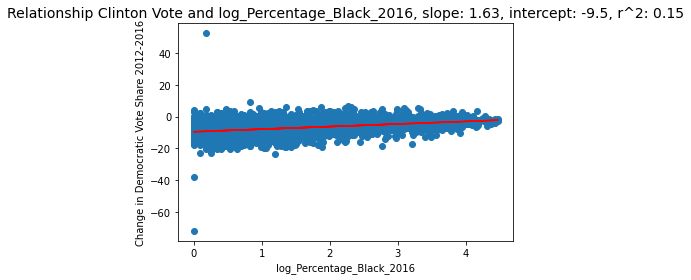

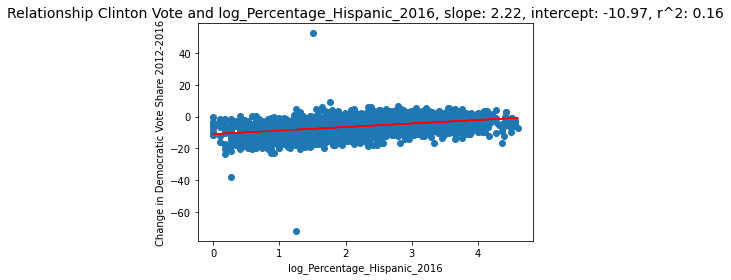

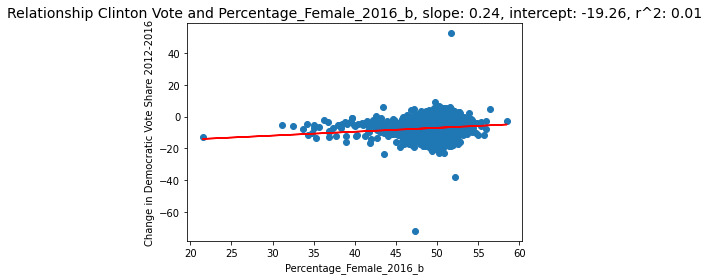

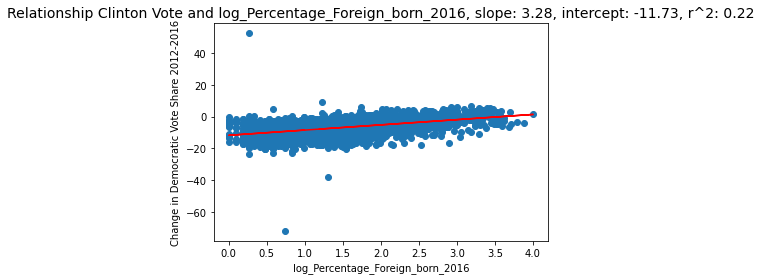

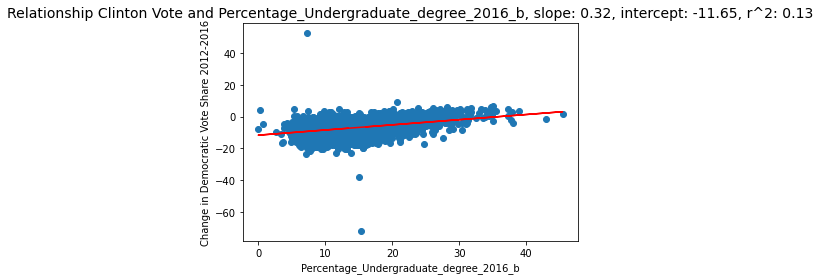

In [85]:
#Generate plots of all independent variables against the change in Democratic Vote share in the 2016 Presidential Election 
for col_name in independent_variables_2016_B:
    
    x=PresData[col_name]
    y=PresData["Clinton_Vote_Change_2016"] 
    m, b = np.polyfit(x, y, 1)
    fittedline=np.poly1d([m,b])
    r2=r2_score(y, fittedline(x))
    plt.plot(x, y, 'o')
    plt.plot(x, m*x+b, color="red")
    plt.title(f'Relationship Clinton Vote and {col_name}, slope: {round(m, 2)}, intercept: {round (b, 2)}, r^2: {round(r2, 2)}', size=14)
    plt.xlabel(col_name, size=10)
    plt.ylabel('Change in Democratic Vote Share 2012-2016', size=10)
    plt.show()


### Description of Independent Variables

Automation1_2016 contains on column measuring the percentage of a county's workforce in job that are susceptable to automation in 2016.

PopEmploy2_2016 adds labour market controls for the percentage change in population between 2011 and 2015, to account for changes in the size of the labour market, and percentage change in employment over the same period to control for unemployment level. 

Given that votes were reported to have varied considerably, based on demographics, Demograph3_2016 adds controls for the percentage of a county’s population that was Asian, Black, Female, Hispanic or Foreign born in 2015, all of which correlated negatively with support for Trump, per exit poll reporting at the time (Frey et al, 2018).

Education4_2016 adds an education control, specifically the percentage of the population over the age of 
25 who hold a bachelor’s degree or equivalent in 2015.

Finally TrumpVote2016 create the dependent vairable to account for the change in Republican voteshare between the 2012 and 2016 Presidential elections.

In [87]:
#Tranches of independent variables for the 2016 Presidential election regressions have already been created

#Create dependent variable
ClintonVote2016 = np.array(PresData["Clinton_Vote_Change_2016"])

### Running the Model

In [88]:
#Regression with no control variables
X = sm.add_constant(Automation1_2016.ravel())
results = sm.OLS(ClintonVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     319.4
Date:                Sun, 01 May 2022   Prob (F-statistic):           4.42e-68
Time:                        22:40:25   Log-Likelihood:                -9340.3
No. Observations:                3107   AIC:                         1.868e+04
Df Residuals:                    3105   BIC:                         1.870e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2295      0.692      7.560      0.0

In [89]:
#Regression with employment control variables
X = sm.add_constant(Employment2_2016)
results = sm.OLS(ClintonVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     167.9
Date:                Sun, 01 May 2022   Prob (F-statistic):           6.03e-70
Time:                        22:43:09   Log-Likelihood:                -9332.9
No. Observations:                3107   AIC:                         1.867e+04
Df Residuals:                    3104   BIC:                         1.869e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [90]:
#Regression with employment and demograpic controls
X = sm.add_constant(Demograph3_2016)
results = sm.OLS(ClintonVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     228.2
Date:                Sun, 01 May 2022   Prob (F-statistic):          6.24e-305
Time:                        22:43:10   Log-Likelihood:                -8772.6
No. Observations:                3107   AIC:                         1.756e+04
Df Residuals:                    3098   BIC:                         1.762e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8554      1.723     -6.880      0.0

In [91]:
#Regression with employment, demograpic, and education controls
X = sm.add_constant(Education4_2016)
results = sm.OLS(ClintonVote2016, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     246.4
Date:                Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                        22:43:10   Log-Likelihood:                -8653.6
No. Observations:                3107   AIC:                         1.733e+04
Df Residuals:                    3097   BIC:                         1.739e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.3475      1.726    -11.210      0.0

## Biden 2020

### Data Manipulation

Since the independent variables are identical to those used  in the Trump 2020 analysis, there is only a need to construct a dependent variable.

In [92]:
#Construct column "Change_Vote_Share_2016" so as to work in percentages when analysing the 2020 Presidental Election
PresData["Biden_Vote_Change_2020"] = PresData["Biden_2020"]*100

#Check it worked
PresData["Biden_Vote_Change_2020"]

0       3.25
1       3.02
2      -0.74
3      -0.55
4       1.14
        ... 
3102    4.16
3103    9.17
3104    2.73
3105    2.28
3106    1.68
Name: Biden_Vote_Change_2020, Length: 3107, dtype: float64

### Data Visualisation

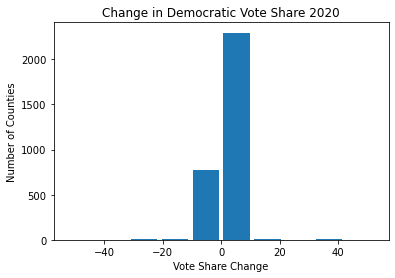

In [93]:
#Plot historgram for the dependent variable for the 2020 election, Change in Democratic Vote Share
plt.hist(PresData["Biden_Vote_Change_2020"], rwidth=0.85)
plt.title('Change in Democratic Vote Share 2020')
plt.xlabel('Vote Share Change')
plt.ylabel('Number of Counties')
plt.show()

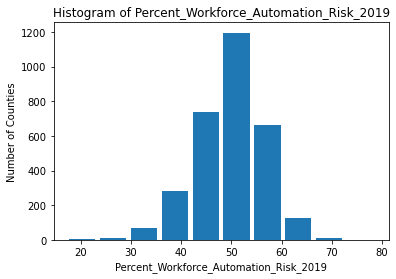

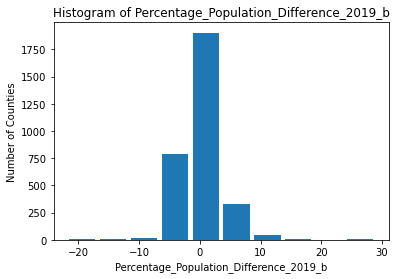

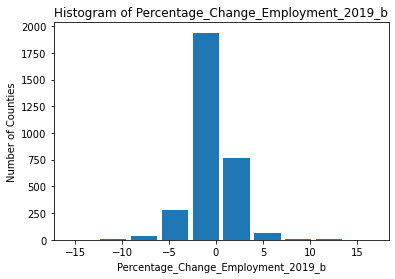

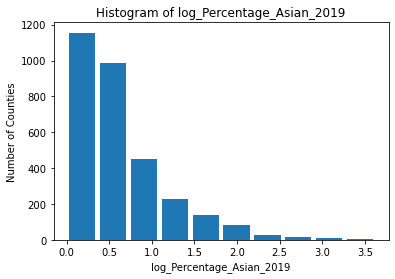

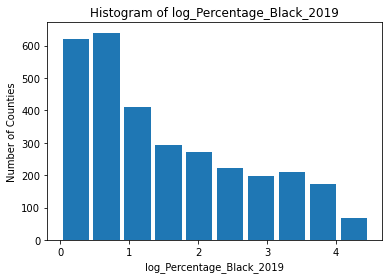

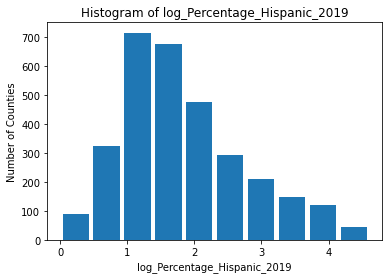

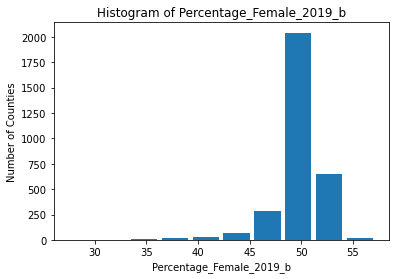

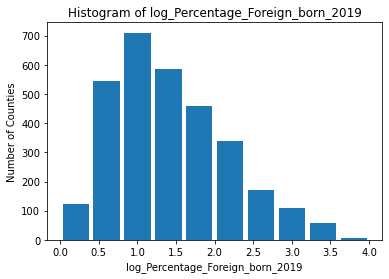

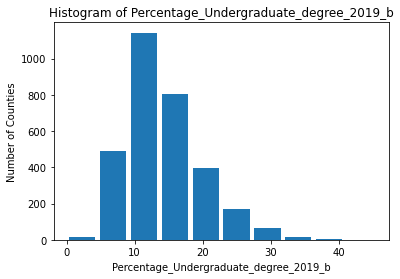

In [94]:
#Plot histograms for the independent variables to be use in the analysis of the 2020 election
for col_name in independent_variables_2019_B:

    x=PresData[col_name]
    plt.hist(x, rwidth=0.85)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Number of Counties')
    plt.show()


Text(0, 0.5, 'Change in Democractic Vote Share 2016-2020')

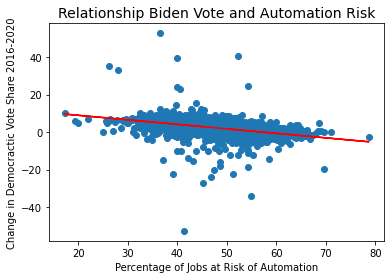

In [95]:
#Generate plot of the change in Democratic vote share against the percentage of jobs at risk of automation

x=PresData["Percent_Workforce_Automation_Risk_2019"]
y=PresData["Biden_Vote_Change_2020"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x+b, color="red")
plt.title('Relationship Biden Vote and Automation Risk', size=14)
plt.xlabel('Percentage of Jobs at Risk of Automation', size=10)
plt.ylabel('Change in Democractic Vote Share 2016-2020', size=10)


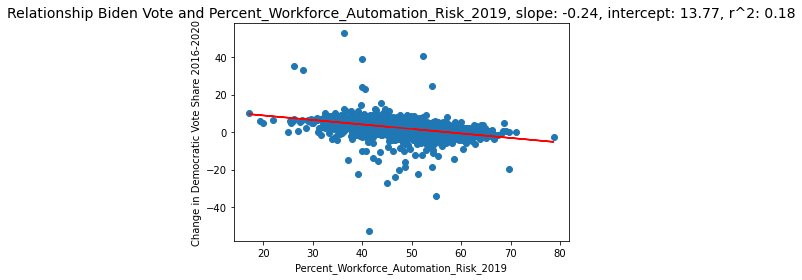

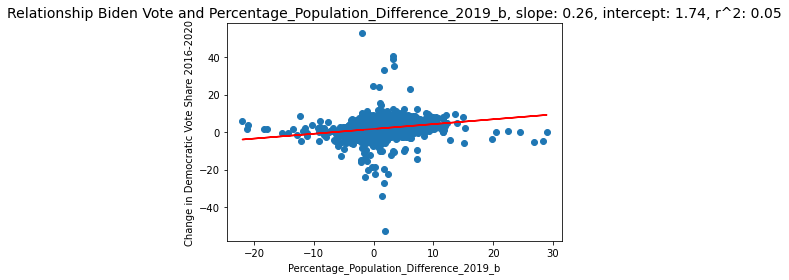

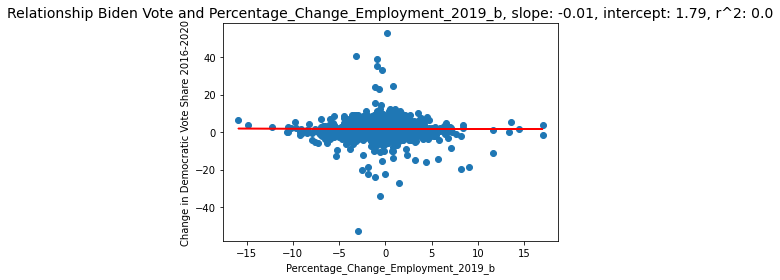

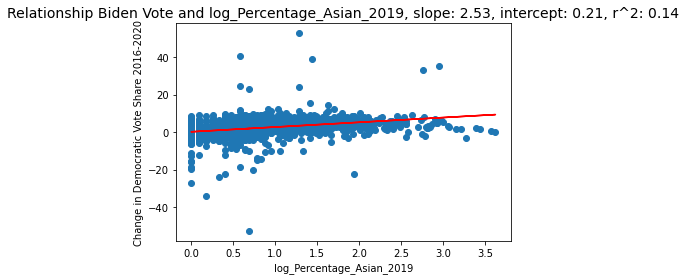

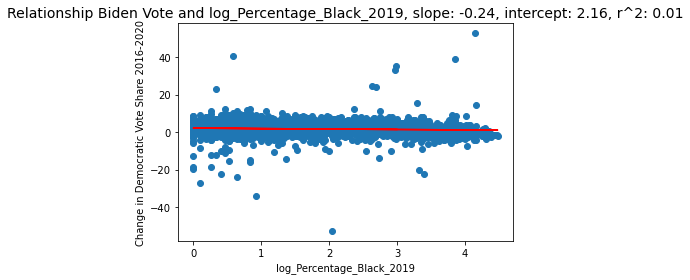

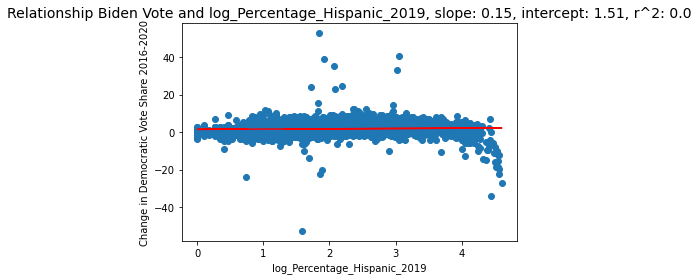

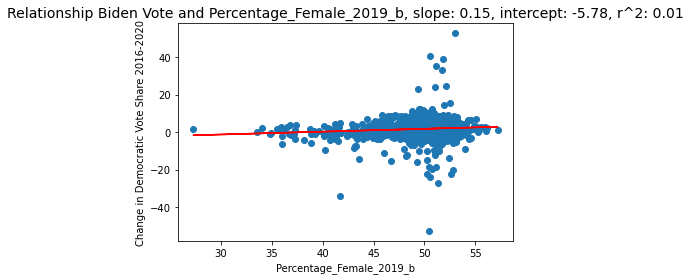

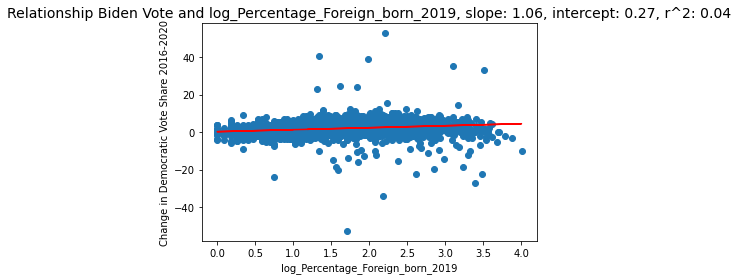

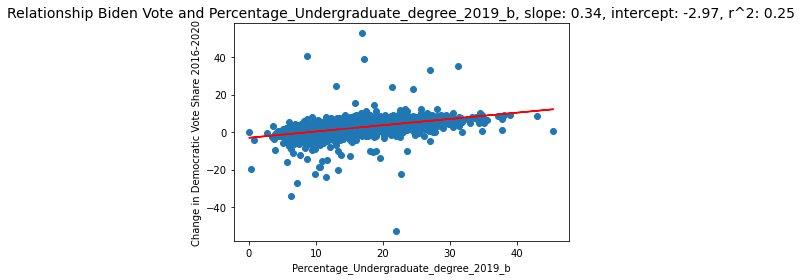

In [96]:
#Generate plots of all independent variables against the change in Democratic Vote share in the 2020 Presidential Election 
for col_name in independent_variables_2019_B:
    
    x=PresData[col_name]
    y=PresData["Biden_Vote_Change_2020"] 
    m, b = np.polyfit(x, y, 1)
    fittedline=np.poly1d([m,b])
    r2=r2_score(y, fittedline(x))
    plt.plot(x, y, 'o')
    plt.plot(x, m*x+b, color="red")
    plt.title(f'Relationship Biden Vote and {col_name}, slope: {round(m, 2)}, intercept: {round (b, 2)}, r^2: {round(r2, 2)}', size=14)
    plt.xlabel(col_name, size=10)
    plt.ylabel('Change in Democratic Vote Share 2016-2020', size=10)
    plt.show()


### Description of Independent Variables

Automation1_2019 contains on column measuring the percentage of a county's workforce in job that were susceptable to automation in 2019.

PopEmploy2_2019 adds labour market controls for the percentage change in population between 2015 and 2019, to account for changes in the size of the labour market, and percentage change in employment over the same period to control for unemployment level. 

Given that votes were reported to have varied considerably, based on demographics, Demograph3_2019 adds controls for the percentage of a county’s population that was Asian, Black, Female, Foreign born in 2019, all of which correlated negatively with support for Trump, per exit poll reporting at the time (Frey et al, 2018). The percentage of the country's population that is Hispanic in 2019 is included for consistency with the 2016 analysis despite correlating positively with support for Trump.

Education4_2019 adds an education control, specifically the percentage of the population over the age of 
25 who hold a bachelor’s degree or equivalent in 2019.

Finally BidenVote2020 create the dependent vairable to account for the change in Republican voteshare between the 2016 and 2020 Presidential elections.

In [97]:
#Create dependent variable
BidenVote2020 = np.array(PresData["Biden_Vote_Change_2020"])

### Running the Model

In [100]:
#Regression with no contorl variables
X = sm.add_constant(Automation1_2019.ravel())
results = sm.OLS(BidenVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     681.6
Date:                Sun, 01 May 2022   Prob (F-statistic):          5.27e-136
Time:                        22:47:31   Log-Likelihood:                -8256.4
No. Observations:                3107   AIC:                         1.652e+04
Df Residuals:                    3105   BIC:                         1.653e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7698      0.463     29.748      0.0

In [101]:
#Regression with employment controls
X = sm.add_constant(PopEmploy2_2019)
results = sm.OLS(BidenVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     265.3
Date:                Sun, 01 May 2022   Prob (F-statistic):          2.72e-153
Time:                        22:49:30   Log-Likelihood:                -8209.9
No. Observations:                3107   AIC:                         1.643e+04
Df Residuals:                    3103   BIC:                         1.645e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [102]:
#Regression with employment and demograpic
X = sm.add_constant(Demograph3_2019)
results = sm.OLS(BidenVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     131.4
Date:                Sun, 01 May 2022   Prob (F-statistic):          3.07e-190
Time:                        22:49:30   Log-Likelihood:                -8110.9
No. Observations:                3107   AIC:                         1.624e+04
Df Residuals:                    3098   BIC:                         1.629e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8637      1.405      4.887      0.0

In [103]:
#Regression with employment, demograpic, and education controls
X = sm.add_constant(Education4_2019)
results = sm.OLS(BidenVote2020, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     135.2
Date:                Sun, 01 May 2022   Prob (F-statistic):          2.09e-215
Time:                        22:49:31   Log-Likelihood:                -8049.9
No. Observations:                3107   AIC:                         1.612e+04
Df Residuals:                    3097   BIC:                         1.618e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9342      1.453      1.331      0.1